In [1]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import pandas as pd

# Function to load and preprocess each participant's EEG CSV individually
def load_dataset_file_by_file(root_folder):
    dataset = []  # List of tuples: (dataframe, label, participant_id)

    for letter_folder in sorted(os.listdir(root_folder)):  # Optional: sort for consistency
        letter_path = os.path.join(root_folder, letter_folder)
        if not os.path.isdir(letter_path):
            print(f"Skipping {letter_path} (not a directory)")
            continue

        print(f"Processing letter folder: {letter_folder}")
        label = letter_folder  # Use folder name as label

        for file in os.listdir(letter_path):
            file_path = os.path.join(letter_path, file)
            if not os.path.isfile(file_path) or not file.endswith('.csv'):
                print(f"  Skipping {file} (not a .csv file)")
                continue

            print(f"  Reading participant file: {file}")
            try:
                df = pd.read_csv(file_path, skiprows=1)

                # Extract participant name using regex
                match = re.match(r'(par\.\d+)', file)
                participant_name = match.group(0) if match else "unknown"

                # Append as a tuple: (dataframe, label, participant_id)
                dataset.append((df, label, participant_name))
            except Exception as e:
                print(f"  Error reading {file_path}: {e}")
                continue

    return dataset

# Example usage
ROOT_FOLDER = "/content/drive/MyDrive/كلمات"
dataset = load_dataset_file_by_file(ROOT_FOLDER)

# Check an example
print(f"\nTotal samples loaded: {len(dataset)}")
print("Example entry:")
df_sample, label_sample, participant_sample = dataset[0]
print(f"Participant: {participant_sample}, Label: {label_sample}")
print(df_sample.head())


Processing letter folder: اختر
  Reading participant file: par.3 اختر_EPOCX_206412_2023.12.24T10.58.33+03.00.md.csv
  Reading participant file: par.20  اختر_EPOCX_206412_2023.12.24T12.49.20+03.00.md.csv
  Reading participant file: par.17 اختر_EPOCX_206412_2023.12.24T13.25.58+03.00.md.csv
  Reading participant file: par.6 اختر_EPOCX_206412_2023.12.21T13.06.47+03.00.md.csv
  Reading participant file: par.11 اختر_EPOCX_206412_2023.12.25T11.16.35+03.00.md.csv
  Reading participant file: par.22 اختر_EPOCX_206412_2023.12.24T14.22.05+03.00.md.csv
  Reading participant file: par.2 اختر_EPOCX_206420_2023.12.25T14.01.11+03.00.md.csv
  Reading participant file: par.14 اختر_EPOCX_206412_2023.12.25T10.47.32+03.00.md.csv
  Reading participant file: par.8 اختر_EPOCX_206412_2023.12.24T11.27.08+03.00.md.csv
  Reading participant file: par.15 اختر_EPOCX_206412_2023.12.24T11.49.28+03.00.md.csv
  Reading participant file: par.7 اختر_EPOCX_206412_2023.12.24T12.18.26+03.00.md.csv
  Reading participant file:

In [5]:
# Metadata columns to exclude from EEG signal channels
METADATA_COLUMNS = ['Time', 'Event Id', 'Event Date', 'Event Duration', 'Event Description']

# Function to validate EEG data for a single DataFrame
def validate_eeg_data(df):
    # Keep only EEG channels (not metadata)
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print("  ❌ No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None

    print(f"  ✅ Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns

# Function to validate all entries in the dataset
def validate_all_eeg_data(dataset):
    validated_dataset = []           # Will store (cleaned_df, label, participant)
    valid_columns_map = {}           # Optional: track valid columns per participant
    skipped = 0

    for idx, (df, label, participant) in enumerate(dataset):
        print(f"\n🔍 Processing sample {idx + 1}/{len(dataset)} - Participant: {participant}, Label: {label}")
        validated_df, valid_columns = validate_eeg_data(df)

        if validated_df is not None:
            validated_dataset.append((validated_df, label, participant))
            valid_columns_map[participant] = valid_columns
        else:
            print(f"  ⚠️ Skipping sample from {participant}")
            skipped += 1

    print(f"\n✅ EEG validation complete. Valid samples: {len(validated_dataset)}, Skipped: {skipped}")
    return validated_dataset, valid_columns_map

# Run validation
validated_dataset, valid_columns_map = validate_all_eeg_data(dataset)

# Optional: Preview
df_example, label_example, participant_example = validated_dataset[0]
print(f"\n👤 Participant: {participant_example}, 🏷️ Label: {label_example}, 📐 EEG shape: {df_example.shape}")



🔍 Processing sample 1/359 - Participant: par.3, Label: اختر
  ✅ Validating data with shape: (1386, 68)

🔍 Processing sample 2/359 - Participant: par.20, Label: اختر
  ✅ Validating data with shape: (1413, 68)

🔍 Processing sample 3/359 - Participant: par.17, Label: اختر
  ✅ Validating data with shape: (1388, 68)

🔍 Processing sample 4/359 - Participant: par.6, Label: اختر
  ✅ Validating data with shape: (1394, 68)

🔍 Processing sample 5/359 - Participant: par.11, Label: اختر
  ✅ Validating data with shape: (1369, 68)

🔍 Processing sample 6/359 - Participant: par.22, Label: اختر
  ✅ Validating data with shape: (1379, 68)

🔍 Processing sample 7/359 - Participant: par.2, Label: اختر
  ✅ Validating data with shape: (1380, 68)

🔍 Processing sample 8/359 - Participant: par.14, Label: اختر
  ✅ Validating data with shape: (1384, 68)

🔍 Processing sample 9/359 - Participant: par.8, Label: اختر
  ✅ Validating data with shape: (1376, 68)

🔍 Processing sample 10/359 - Participant: par.15, Label: ا

In [6]:
CHANNELS_TO_REMOVE = ['EEG.T8', 'EEG.O1', 'EEG.F3']
DESIRED_EEG_CHANNELS = [
    'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7',
    'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4'
]

def clean_validated_dataset(validated_dataset):
    cleaned_dataset = []

    for idx, (df, label, participant) in enumerate(validated_dataset):
        print(f"\n🧹 Cleaning sample {idx + 1}/{len(validated_dataset)} - Participant: {participant}, Label: {label}")

        # Select only desired channels first
        available_channels = [ch for ch in DESIRED_EEG_CHANNELS if ch in df.columns]
        df_cleaned = df[available_channels].copy()

        # Drop the undesired ones explicitly
        removed_channels = [ch for ch in CHANNELS_TO_REMOVE if ch in df_cleaned.columns]
        df_cleaned.drop(columns=removed_channels, inplace=True)

        print(f"  Removed channels: {removed_channels}")
        print(f"  Shape after cleaning: {df_cleaned.shape}")

        cleaned_dataset.append((df_cleaned, label, participant))

    print(f"\n✅ Finished cleaning all EEG samples. Total cleaned samples: {len(cleaned_dataset)}")
    return cleaned_dataset

# Run the cleaning step
cleaned_dataset = clean_validated_dataset(validated_dataset)

# Example check
df_clean, label_clean, participant_clean = cleaned_dataset[0]
print(f"\n👤 Participant: {participant_clean}, 🏷️ Label: {label_clean}, 📐 Cleaned EEG shape: {df_clean.shape}")



🧹 Cleaning sample 1/359 - Participant: par.3, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1386, 11)

🧹 Cleaning sample 2/359 - Participant: par.20, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1413, 11)

🧹 Cleaning sample 3/359 - Participant: par.17, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1388, 11)

🧹 Cleaning sample 4/359 - Participant: par.6, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1394, 11)

🧹 Cleaning sample 5/359 - Participant: par.11, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1369, 11)

🧹 Cleaning sample 6/359 - Participant: par.22, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cleaning: (1379, 11)

🧹 Cleaning sample 7/359 - Participant: par.2, Label: اختر
  Removed channels: ['EEG.T8', 'EEG.O1', 'EEG.F3']
  Shape after cl

In [7]:
import mne

FS = 128  # Set your actual sampling frequency here

# Function to create an MNE Raw object
def create_raw_object(eeg_data, sfreq=FS):
    data = eeg_data.to_numpy().T  # Transpose to shape (n_channels, n_times)
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info, verbose=False)
    return raw

# Function to rename EEG channels for standard montage compatibility
def rename_eeg_channels(raw_object):
    rename_dict = {
        'EEG.AF3': 'AF3', 'EEG.FC6': 'FC6', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
        'EEG.FC5': 'FC5', 'EEG.T7': 'T7', 'EEG.O2': 'O2',
        'EEG.P7': 'P7', 'EEG.P8': 'P8',
        'EEG.F4': 'F4', 'EEG.F8': 'F8'
    }


    raw_object.rename_channels(rename_dict)
    return raw_object

# Create Raw objects for each cleaned entry (per participant)
raw_dataset = []  # Will store (raw_object, label, participant)

for idx, (df_clean, label, participant) in enumerate(cleaned_dataset):
    print(f"\n🧠 Creating Raw object {idx + 1}/{len(cleaned_dataset)} - Participant: {participant}, Label: {label}")

    try:
        raw = create_raw_object(df_clean)
        raw = rename_eeg_channels(raw)
        raw_dataset.append((raw, label, participant))
        print("  ✅ Successfully created and renamed Raw object.")
    except Exception as e:
        print(f"  ❌ Failed to create Raw object for {participant}, label {label}: {e}")



🧠 Creating Raw object 1/359 - Participant: par.3, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 2/359 - Participant: par.20, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 3/359 - Participant: par.17, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 4/359 - Participant: par.6, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 5/359 - Participant: par.11, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 6/359 - Participant: par.22, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 7/359 - Participant: par.2, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 8/359 - Participant: par.14, Label: اختر
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 9/359 - Participant: par.8, Label: اختر
  ✅ Successfully created and renamed

In [8]:
from mne.preprocessing import ICA
from mne_icalabel import label_components
import numpy as np

# Apply filters and referencing to a Raw object
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0, verbose=False)
    raw.filter(l_freq=1.0, h_freq=50.0, verbose=False)
    raw.set_eeg_reference('average', projection=True, verbose=False)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    print("  ✅ Filters and referencing applied.")
    return raw

# Perform ICA and clean artifacts for a Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=11, max_iter=1000, random_state=42)
    ica.fit(raw, verbose=False)

    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]

    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw.copy(), verbose=False)

    print(f"  ✅ ICA completed. Excluded components: {non_brain_components}")
    return raw_cleaned

# Check and clean NaN/Inf values from Raw data
def clean_nan_inf(raw):
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("  ⚠️ Detected NaN or Inf values.")
        for i in range(data.shape[0]):
            channel_data = data[i, :]
            channel_mean = np.nanmean(channel_data)
            channel_data[np.isnan(channel_data)] = channel_mean
            channel_data[np.isinf(channel_data)] = channel_mean
            data[i, :] = channel_data
        print("  ✅ NaN/Inf values replaced with channel means.")
    else:
        print("  ✅ No NaN or Inf values detected.")
    raw._data = data
    return raw

# Final cleaned raw dataset: list of (raw_object, label, participant)
cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(raw_dataset):
    print(f"\n🧪 Processing sample {idx + 1}/{len(raw_dataset)} - Participant: {participant}, Label: {label}")
    try:
        raw = apply_filters_and_reference(raw_object)
        raw = clean_nan_inf(raw)
        raw = perform_ica(raw)
        cleaned_raw_dataset.append((raw, label, participant))
        print(f"  ✅ Successfully processed sample for {participant} ({label})")
    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 10]
  ✅ Successfully processed sample for par.4 (اسفل)

🧪 Processing sample 38/359 - Participant: par.9, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7]
  ✅ Successfully processed sample for par.9 (اسفل)

🧪 Processing sample 39/359 - Participant: par.16, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (اسفل)

🧪 Processing sample 40/359 - Participant: par.13, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.13 (اسفل)

🧪 Processing sample 41/359 - Participant: par.5, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9]
  ✅ Successfully processed sample for par.5 (اسفل)

🧪 Processing sample 42/359 - Participant: par.6, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.6 (اسفل)

🧪 Processing sample 43/359 - Participant: par.21, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (اسفل)

🧪 Processing sample 44/359 - Participant: par.22, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.22 (اسفل)

🧪 Processing sample 45/359 - Participant: unknown, Label: اسفل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 8]
  ✅ Successfully processed sample for unknown (اسفل)

🧪 Processing sample 46/359 - Participant: par.15, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (اعلى)

🧪 Processing sample 47/359 - Participant: par.5, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2]
  ✅ Successfully processed sample for par.5 (اعلى)

🧪 Processing sample 48/359 - Participant: par.9, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 9, 10]
  ✅ Successfully processed sample for par.9 (اعلى)

🧪 Processing sample 49/359 - Participant: par.19, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.19 (اعلى)

🧪 Processing sample 50/359 - Participant: par.14, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 7]
  ✅ Successfully processed sample for par.14 (اعلى)

🧪 Processing sample 51/359 - Participant: par.16, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.16 (اعلى)

🧪 Processing sample 52/359 - Participant: par.21, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (اعلى)

🧪 Processing sample 53/359 - Participant: par.3, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 10]
  ✅ Successfully processed sample for par.3 (اعلى)

🧪 Processing sample 54/359 - Participant: par.22, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7]
  ✅ Successfully processed sample for par.22 (اعلى)

🧪 Processing sample 55/359 - Participant: par.11, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9]
  ✅ Successfully processed sample for par.11 (اعلى)

🧪 Processing sample 56/359 - Participant: par.10, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 10]
  ✅ Successfully processed sample for par.10 (اعلى)

🧪 Processing sample 57/359 - Participant: par.4, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 10]
  ✅ Successfully processed sample for par.4 (اعلى)

🧪 Processing sample 58/359 - Participant: par.18, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (اعلى)

🧪 Processing sample 59/359 - Participant: par.6, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.6 (اعلى)

🧪 Processing sample 60/359 - Participant: par.2, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 9, 10]
  ✅ Successfully processed sample for par.2 (اعلى)

🧪 Processing sample 61/359 - Participant: par.12, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.12 (اعلى)

🧪 Processing sample 62/359 - Participant: par.20, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 7, 8]
  ✅ Successfully processed sample for par.20 (اعلى)

🧪 Processing sample 63/359 - Participant: par.13, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 10]
  ✅ Successfully processed sample for par.13 (اعلى)

🧪 Processing sample 64/359 - Participant: par.7, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 8, 10]
  ✅ Successfully processed sample for par.7 (اعلى)

🧪 Processing sample 65/359 - Participant: par.17, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (اعلى)

🧪 Processing sample 66/359 - Participant: par.8, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 6, 8, 10]
  ✅ Successfully processed sample for par.8 (اعلى)

🧪 Processing sample 67/359 - Participant: par.12, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 9]
  ✅ Successfully processed sample for par.12 (اعلى)

🧪 Processing sample 68/359 - Participant: par.1, Label: اعلى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.1 (اعلى)

🧪 Processing sample 69/359 - Participant: par.11, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.11 (انذار)

🧪 Processing sample 70/359 - Participant: par.14, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 7, 8]
  ✅ Successfully processed sample for par.14 (انذار)

🧪 Processing sample 71/359 - Participant: par.3, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 9, 10]
  ✅ Successfully processed sample for par.3 (انذار)

🧪 Processing sample 72/359 - Participant: par.16, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 9]
  ✅ Successfully processed sample for par.16 (انذار)

🧪 Processing sample 73/359 - Participant: par.6, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.6 (انذار)

🧪 Processing sample 74/359 - Participant: par.12, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7]
  ✅ Successfully processed sample for par.12 (انذار)

🧪 Processing sample 75/359 - Participant: par.17, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.17 (انذار)

🧪 Processing sample 76/359 - Participant: par.7, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 10]
  ✅ Successfully processed sample for par.7 (انذار)

🧪 Processing sample 77/359 - Participant: par.10, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 9]
  ✅ Successfully processed sample for par.10 (انذار)

🧪 Processing sample 78/359 - Participant: par.21, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 8]
  ✅ Successfully processed sample for par.21 (انذار)

🧪 Processing sample 79/359 - Participant: par.19, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 10]
  ✅ Successfully processed sample for par.19 (انذار)

🧪 Processing sample 80/359 - Participant: par.9, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6]
  ✅ Successfully processed sample for par.9 (انذار)

🧪 Processing sample 81/359 - Participant: par.22, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 7, 9]
  ✅ Successfully processed sample for par.22 (انذار)

🧪 Processing sample 82/359 - Participant: par.2, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 9]
  ✅ Successfully processed sample for par.2 (انذار)

🧪 Processing sample 83/359 - Participant: par.15, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 9]
  ✅ Successfully processed sample for par.15 (انذار)

🧪 Processing sample 84/359 - Participant: par.20, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8]
  ✅ Successfully processed sample for par.20 (انذار)

🧪 Processing sample 85/359 - Participant: par.8, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 8, 10]
  ✅ Successfully processed sample for par.8 (انذار)

🧪 Processing sample 86/359 - Participant: par.5, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 10]
  ✅ Successfully processed sample for par.5 (انذار)

🧪 Processing sample 87/359 - Participant: par.13, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 8, 9]
  ✅ Successfully processed sample for par.13 (انذار)

🧪 Processing sample 88/359 - Participant: par.4, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.4 (انذار)

🧪 Processing sample 89/359 - Participant: par.18, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0]
  ✅ Successfully processed sample for par.18 (انذار)

🧪 Processing sample 90/359 - Participant: par.1, Label: انذار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 9, 10]
  ✅ Successfully processed sample for par.1 (انذار)

🧪 Processing sample 91/359 - Participant: par.11, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.11 (ايقاف تشغيل)

🧪 Processing sample 92/359 - Participant: par.5, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 8]
  ✅ Successfully processed sample for par.5 (ايقاف تشغيل)

🧪 Processing sample 93/359 - Participant: par.18, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4]
  ✅ Successfully processed sample for par.18 (ايقاف تشغيل)

🧪 Processing sample 94/359 - Participant: par.16, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.16 (ايقاف تشغيل)

🧪 Processing sample 95/359 - Participant: par.8, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.8 (ايقاف تشغيل)

🧪 Processing sample 96/359 - Participant: par.6, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (ايقاف تشغيل)

🧪 Processing sample 97/359 - Participant: par.4, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 8, 10]
  ✅ Successfully processed sample for par.4 (ايقاف تشغيل)

🧪 Processing sample 98/359 - Participant: par.12, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 8, 10]
  ✅ Successfully processed sample for par.12 (ايقاف تشغيل)

🧪 Processing sample 99/359 - Participant: par.22, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7]
  ✅ Successfully processed sample for par.22 (ايقاف تشغيل)

🧪 Processing sample 100/359 - Participant: par.7, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 10]
  ✅ Successfully processed sample for par.7 (ايقاف تشغيل)

🧪 Processing sample 101/359 - Participant: par.9, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8]
  ✅ Successfully processed sample for par.9 (ايقاف تشغيل)

🧪 Processing sample 102/359 - Participant: par.13, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.13 (ايقاف تشغيل)

🧪 Processing sample 103/359 - Participant: par.20, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 10]
  ✅ Successfully processed sample for par.20 (ايقاف تشغيل)

🧪 Processing sample 104/359 - Participant: par.3, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (ايقاف تشغيل)

🧪 Processing sample 105/359 - Participant: par.17, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.17 (ايقاف تشغيل)

🧪 Processing sample 106/359 - Participant: par.21, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 9]
  ✅ Successfully processed sample for par.21 (ايقاف تشغيل)

🧪 Processing sample 107/359 - Participant: par.2, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 7]
  ✅ Successfully processed sample for par.2 (ايقاف تشغيل)

🧪 Processing sample 108/359 - Participant: par.15, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (ايقاف تشغيل)

🧪 Processing sample 109/359 - Participant: par.14, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7, 9]
  ✅ Successfully processed sample for par.14 (ايقاف تشغيل)

🧪 Processing sample 110/359 - Participant: par.23, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 9]
  ✅ Successfully processed sample for par.23 (ايقاف تشغيل)

🧪 Processing sample 111/359 - Participant: par.10, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8]
  ✅ Successfully processed sample for par.10 (ايقاف تشغيل)

🧪 Processing sample 112/359 - Participant: par.5, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10]
  ✅ Successfully processed sample for par.5 (ايقاف تشغيل)

🧪 Processing sample 113/359 - Participant: par.1, Label: ايقاف تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10]
  ✅ Successfully processed sample for par.1 (ايقاف تشغيل)

🧪 Processing sample 114/359 - Participant: par.3, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (تشغيل)

🧪 Processing sample 115/359 - Participant: par.17, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9]
  ✅ Successfully processed sample for par.17 (تشغيل)

🧪 Processing sample 116/359 - Participant: par.21, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8]
  ✅ Successfully processed sample for par.21 (تشغيل)

🧪 Processing sample 117/359 - Participant: par.14, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 7, 10]
  ✅ Successfully processed sample for par.14 (تشغيل)

🧪 Processing sample 118/359 - Participant: par.4, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 10]
  ✅ Successfully processed sample for par.4 (تشغيل)

🧪 Processing sample 119/359 - Participant: par.12, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 8, 10]
  ✅ Successfully processed sample for par.12 (تشغيل)

🧪 Processing sample 120/359 - Participant: par.15, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 9, 10]
  ✅ Successfully processed sample for par.15 (تشغيل)

🧪 Processing sample 121/359 - Participant: par.9, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6]
  ✅ Successfully processed sample for par.9 (تشغيل)

🧪 Processing sample 122/359 - Participant: par.2, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 9]
  ✅ Successfully processed sample for par.2 (تشغيل)

🧪 Processing sample 123/359 - Participant: par.6, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 9]
  ✅ Successfully processed sample for par.6 (تشغيل)

🧪 Processing sample 124/359 - Participant: par.11, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5]
  ✅ Successfully processed sample for par.11 (تشغيل)

🧪 Processing sample 125/359 - Participant: par.10, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 9, 10]
  ✅ Successfully processed sample for par.10 (تشغيل)

🧪 Processing sample 126/359 - Participant: par.19, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.19 (تشغيل)

🧪 Processing sample 127/359 - Participant: par.13, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.13 (تشغيل)

🧪 Processing sample 128/359 - Participant: par.16, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.16 (تشغيل)

🧪 Processing sample 129/359 - Participant: par.20, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.20 (تشغيل)

🧪 Processing sample 130/359 - Participant: par.22, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 9, 10]
  ✅ Successfully processed sample for par.22 (تشغيل)

🧪 Processing sample 131/359 - Participant: par.5, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10]
  ✅ Successfully processed sample for par.5 (تشغيل)

🧪 Processing sample 132/359 - Participant: par.18, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.18 (تشغيل)

🧪 Processing sample 133/359 - Participant: par.8, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (تشغيل)

🧪 Processing sample 134/359 - Participant: par.7, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.7 (تشغيل)

🧪 Processing sample 135/359 - Participant: par.1, Label: تشغيل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (تشغيل)

🧪 Processing sample 136/359 - Participant: par.9, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 10]
  ✅ Successfully processed sample for par.9 (جوع)

🧪 Processing sample 137/359 - Participant: par.2, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4]
  ✅ Successfully processed sample for par.2 (جوع)

🧪 Processing sample 138/359 - Participant: par.19, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9]
  ✅ Successfully processed sample for par.19 (جوع)

🧪 Processing sample 139/359 - Participant: par.3, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.3 (جوع)

🧪 Processing sample 140/359 - Participant: par.4, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 10]
  ✅ Successfully processed sample for par.4 (جوع)

🧪 Processing sample 141/359 - Participant: par.20, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6]
  ✅ Successfully processed sample for par.20 (جوع)

🧪 Processing sample 142/359 - Participant: par.10, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.10 (جوع)

🧪 Processing sample 143/359 - Participant: par.17, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9]
  ✅ Successfully processed sample for par.17 (جوع)

🧪 Processing sample 144/359 - Participant: par.15, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9]
  ✅ Successfully processed sample for par.15 (جوع)

🧪 Processing sample 145/359 - Participant: par.12, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 9]
  ✅ Successfully processed sample for par.12 (جوع)

🧪 Processing sample 146/359 - Participant: par.11, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 10]
  ✅ Successfully processed sample for par.11 (جوع)

🧪 Processing sample 147/359 - Participant: par.14, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8]
  ✅ Successfully processed sample for par.14 (جوع)

🧪 Processing sample 148/359 - Participant: par.6, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 6, 7]
  ✅ Successfully processed sample for par.6 (جوع)

🧪 Processing sample 149/359 - Participant: par.7, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.7 (جوع)

🧪 Processing sample 150/359 - Participant: par.5, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 10]
  ✅ Successfully processed sample for par.5 (جوع)

🧪 Processing sample 151/359 - Participant: par.16, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.16 (جوع)

🧪 Processing sample 152/359 - Participant: par.13, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 8]
  ✅ Successfully processed sample for par.13 (جوع)

🧪 Processing sample 153/359 - Participant: par.18, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 9]
  ✅ Successfully processed sample for par.18 (جوع)

🧪 Processing sample 154/359 - Participant: par.21, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 8]
  ✅ Successfully processed sample for par.21 (جوع)

🧪 Processing sample 155/359 - Participant: par.8, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 10]
  ✅ Successfully processed sample for par.8 (جوع)

🧪 Processing sample 156/359 - Participant: par.1, Label: جوع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.1 (جوع)

🧪 Processing sample 157/359 - Participant: par.17, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 6, 8]
  ✅ Successfully processed sample for par.17 (حذف)

🧪 Processing sample 158/359 - Participant: par.5, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (حذف)

🧪 Processing sample 159/359 - Participant: par.16, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 10]
  ✅ Successfully processed sample for par.16 (حذف)

🧪 Processing sample 160/359 - Participant: par.14, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 9]
  ✅ Successfully processed sample for par.14 (حذف)

🧪 Processing sample 161/359 - Participant: par.4, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10]
  ✅ Successfully processed sample for par.4 (حذف)

🧪 Processing sample 162/359 - Participant: par.8, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10]
  ✅ Successfully processed sample for par.8 (حذف)

🧪 Processing sample 163/359 - Participant: par.10, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2]
  ✅ Successfully processed sample for par.10 (حذف)

🧪 Processing sample 164/359 - Participant: par.3, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 9]
  ✅ Successfully processed sample for par.3 (حذف)

🧪 Processing sample 165/359 - Participant: par.2, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9]
  ✅ Successfully processed sample for par.2 (حذف)

🧪 Processing sample 166/359 - Participant: par.21, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.21 (حذف)

🧪 Processing sample 167/359 - Participant: par.6, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (حذف)

🧪 Processing sample 168/359 - Participant: par.19, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7]
  ✅ Successfully processed sample for par.19 (حذف)

🧪 Processing sample 169/359 - Participant: par.18, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10]
  ✅ Successfully processed sample for par.18 (حذف)

🧪 Processing sample 170/359 - Participant: par.7, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9]
  ✅ Successfully processed sample for par.7 (حذف)

🧪 Processing sample 171/359 - Participant: par.11, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 10]
  ✅ Successfully processed sample for par.11 (حذف)

🧪 Processing sample 172/359 - Participant: par.15, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (حذف)

🧪 Processing sample 173/359 - Participant: par.1, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 8, 9]
  ✅ Successfully processed sample for par.1 (حذف)

🧪 Processing sample 174/359 - Participant: par.20, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9]
  ✅ Successfully processed sample for par.20 (حذف)

🧪 Processing sample 175/359 - Participant: par.13, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 9]
  ✅ Successfully processed sample for par.13 (حذف)

🧪 Processing sample 176/359 - Participant: par.12, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6]
  ✅ Successfully processed sample for par.12 (حذف)

🧪 Processing sample 177/359 - Participant: par.9, Label: حذف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7]
  ✅ Successfully processed sample for par.9 (حذف)

🧪 Processing sample 178/359 - Participant: par.14, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5]
  ✅ Successfully processed sample for par.14 (حمام)

🧪 Processing sample 179/359 - Participant: par.16, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (حمام)

🧪 Processing sample 180/359 - Participant: par.4, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 10]
  ✅ Successfully processed sample for par.4 (حمام)

🧪 Processing sample 181/359 - Participant: par.21, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (حمام)

🧪 Processing sample 182/359 - Participant: par.20, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.20 (حمام)

🧪 Processing sample 183/359 - Participant: par.6, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.6 (حمام)

🧪 Processing sample 184/359 - Participant: par.15, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 6, 8]
  ✅ Successfully processed sample for par.15 (حمام)

🧪 Processing sample 185/359 - Participant: par.3, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 8]
  ✅ Successfully processed sample for par.3 (حمام)

🧪 Processing sample 186/359 - Participant: unknown, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 7]
  ✅ Successfully processed sample for unknown (حمام)

🧪 Processing sample 187/359 - Participant: par.5, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0]
  ✅ Successfully processed sample for par.5 (حمام)

🧪 Processing sample 188/359 - Participant: par.7, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9]
  ✅ Successfully processed sample for par.7 (حمام)

🧪 Processing sample 189/359 - Participant: par.22, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 8]
  ✅ Successfully processed sample for par.22 (حمام)

🧪 Processing sample 190/359 - Participant: par.11, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 9, 10]
  ✅ Successfully processed sample for par.11 (حمام)

🧪 Processing sample 191/359 - Participant: par.13, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.13 (حمام)

🧪 Processing sample 192/359 - Participant: par.1, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.1 (حمام)

🧪 Processing sample 193/359 - Participant: par.17, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.17 (حمام)

🧪 Processing sample 194/359 - Participant: par.8, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 7]
  ✅ Successfully processed sample for par.8 (حمام)

🧪 Processing sample 195/359 - Participant: par.10, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 9, 10]
  ✅ Successfully processed sample for par.10 (حمام)

🧪 Processing sample 196/359 - Participant: par.12, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 9, 10]
  ✅ Successfully processed sample for par.12 (حمام)

🧪 Processing sample 197/359 - Participant: par.19, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 9]
  ✅ Successfully processed sample for par.19 (حمام)

🧪 Processing sample 198/359 - Participant: par.18, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6]
  ✅ Successfully processed sample for par.18 (حمام)

🧪 Processing sample 199/359 - Participant: par.15, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.15 (حمام)

🧪 Processing sample 200/359 - Participant: par.9, Label: حمام
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8]
  ✅ Successfully processed sample for par.9 (حمام)

🧪 Processing sample 201/359 - Participant: par.11, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 8]
  ✅ Successfully processed sample for par.11 (دواء)

🧪 Processing sample 202/359 - Participant: par.10, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 8]
  ✅ Successfully processed sample for par.10 (دواء)

🧪 Processing sample 203/359 - Participant: par.9, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 10]
  ✅ Successfully processed sample for par.9 (دواء)

🧪 Processing sample 204/359 - Participant: par.13, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 7]
  ✅ Successfully processed sample for par.13 (دواء)

🧪 Processing sample 205/359 - Participant: par.3, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4]
  ✅ Successfully processed sample for par.3 (دواء)

🧪 Processing sample 206/359 - Participant: par.22, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 8]
  ✅ Successfully processed sample for par.22 (دواء)

🧪 Processing sample 207/359 - Participant: par.4, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.4 (دواء)

🧪 Processing sample 208/359 - Participant: unknown, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 8, 9, 10]
  ✅ Successfully processed sample for unknown (دواء)

🧪 Processing sample 209/359 - Participant: par.18, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (دواء)

🧪 Processing sample 210/359 - Participant: par.12, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 9]
  ✅ Successfully processed sample for par.12 (دواء)

🧪 Processing sample 211/359 - Participant: par.8, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 10]
  ✅ Successfully processed sample for par.8 (دواء)

🧪 Processing sample 212/359 - Participant: par.1, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 10]
  ✅ Successfully processed sample for par.1 (دواء)

🧪 Processing sample 213/359 - Participant: par.17, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8]
  ✅ Successfully processed sample for par.17 (دواء)

🧪 Processing sample 214/359 - Participant: par.6, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.6 (دواء)

🧪 Processing sample 215/359 - Participant: par.14, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 8]
  ✅ Successfully processed sample for par.14 (دواء)

🧪 Processing sample 216/359 - Participant: par.5, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8]
  ✅ Successfully processed sample for par.5 (دواء)

🧪 Processing sample 217/359 - Participant: par.20, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 10]
  ✅ Successfully processed sample for par.20 (دواء)

🧪 Processing sample 218/359 - Participant: par.16, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (دواء)

🧪 Processing sample 219/359 - Participant: par.21, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.21 (دواء)

🧪 Processing sample 220/359 - Participant: par.15, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 9]
  ✅ Successfully processed sample for par.15 (دواء)

🧪 Processing sample 221/359 - Participant: par.23, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5]
  ✅ Successfully processed sample for par.23 (دواء)

🧪 Processing sample 222/359 - Participant: par.19, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.19 (دواء)

🧪 Processing sample 223/359 - Participant: par.2, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5]
  ✅ Successfully processed sample for par.2 (دواء)

🧪 Processing sample 224/359 - Participant: par.7, Label: دواء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 9, 10]
  ✅ Successfully processed sample for par.7 (دواء)

🧪 Processing sample 225/359 - Participant: par.13, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 8]
  ✅ Successfully processed sample for par.13 (عطش)

🧪 Processing sample 226/359 - Participant: par.15, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10]
  ✅ Successfully processed sample for par.15 (عطش)

🧪 Processing sample 227/359 - Participant: par.8, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (عطش)

🧪 Processing sample 228/359 - Participant: par.22, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 8, 9]
  ✅ Successfully processed sample for par.22 (عطش)

🧪 Processing sample 229/359 - Participant: par.10, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 10]
  ✅ Successfully processed sample for par.10 (عطش)

🧪 Processing sample 230/359 - Participant: unknown, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 10]
  ✅ Successfully processed sample for unknown (عطش)

🧪 Processing sample 231/359 - Participant: par.20, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 7, 9]
  ✅ Successfully processed sample for par.20 (عطش)

🧪 Processing sample 232/359 - Participant: par.7, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8]
  ✅ Successfully processed sample for par.7 (عطش)

🧪 Processing sample 233/359 - Participant: par.14, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 8]
  ✅ Successfully processed sample for par.14 (عطش)

🧪 Processing sample 234/359 - Participant: par.1, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 10]
  ✅ Successfully processed sample for par.1 (عطش)

🧪 Processing sample 235/359 - Participant: par.17, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (عطش)

🧪 Processing sample 236/359 - Participant: par.11, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 8, 10]
  ✅ Successfully processed sample for par.11 (عطش)

🧪 Processing sample 237/359 - Participant: par.18, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 9]
  ✅ Successfully processed sample for par.18 (عطش)

🧪 Processing sample 238/359 - Participant: par.3, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8, 10]
  ✅ Successfully processed sample for par.3 (عطش)

🧪 Processing sample 239/359 - Participant: par.9, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.9 (عطش)

🧪 Processing sample 240/359 - Participant: par.5, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 10]
  ✅ Successfully processed sample for par.5 (عطش)

🧪 Processing sample 241/359 - Participant: par.4, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 9, 10]
  ✅ Successfully processed sample for par.4 (عطش)

🧪 Processing sample 242/359 - Participant: par.19, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 10]
  ✅ Successfully processed sample for par.19 (عطش)

🧪 Processing sample 243/359 - Participant: par.2, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 10]
  ✅ Successfully processed sample for par.2 (عطش)

🧪 Processing sample 244/359 - Participant: par.12, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 8, 10]
  ✅ Successfully processed sample for par.12 (عطش)

🧪 Processing sample 245/359 - Participant: par.15, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6]
  ✅ Successfully processed sample for par.15 (عطش)

🧪 Processing sample 246/359 - Participant: par.6, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (عطش)

🧪 Processing sample 247/359 - Participant: par.16, Label: عطش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (عطش)

🧪 Processing sample 248/359 - Participant: par.10, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 8, 9]
  ✅ Successfully processed sample for par.10 (لا)

🧪 Processing sample 249/359 - Participant: par.12, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8]
  ✅ Successfully processed sample for par.12 (لا)

🧪 Processing sample 250/359 - Participant: par.8, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (لا)

🧪 Processing sample 251/359 - Participant: par.22, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 8, 10]
  ✅ Successfully processed sample for par.22 (لا)

🧪 Processing sample 252/359 - Participant: par.13, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 9]
  ✅ Successfully processed sample for par.13 (لا)

🧪 Processing sample 253/359 - Participant: par.21, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.21 (لا)

🧪 Processing sample 254/359 - Participant: par.15, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.15 (لا)

🧪 Processing sample 255/359 - Participant: par.7, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 9]
  ✅ Successfully processed sample for par.7 (لا)

🧪 Processing sample 256/359 - Participant: par.2, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7, 10]
  ✅ Successfully processed sample for par.2 (لا)

🧪 Processing sample 257/359 - Participant: par.11, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8]
  ✅ Successfully processed sample for par.11 (لا)

🧪 Processing sample 258/359 - Participant: par.3, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 9, 10]
  ✅ Successfully processed sample for par.3 (لا)

🧪 Processing sample 259/359 - Participant: par.17, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.17 (لا)

🧪 Processing sample 260/359 - Participant: par.5, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.5 (لا)

🧪 Processing sample 261/359 - Participant: par.19, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 8]
  ✅ Successfully processed sample for par.19 (لا)

🧪 Processing sample 262/359 - Participant: par.20, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.20 (لا)

🧪 Processing sample 263/359 - Participant: par.18, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 7, 8]
  ✅ Successfully processed sample for par.18 (لا)

🧪 Processing sample 264/359 - Participant: par.16, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (لا)

🧪 Processing sample 265/359 - Participant: par.4, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.4 (لا)

🧪 Processing sample 266/359 - Participant: par.9, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 9]
  ✅ Successfully processed sample for par.9 (لا)

🧪 Processing sample 267/359 - Participant: par.14, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 8]
  ✅ Successfully processed sample for par.14 (لا)

🧪 Processing sample 268/359 - Participant: par.6, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 7, 9, 10]
  ✅ Successfully processed sample for par.6 (لا)

🧪 Processing sample 269/359 - Participant: par.1, Label: لا
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (لا)

🧪 Processing sample 270/359 - Participant: par.4, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 10]
  ✅ Successfully processed sample for par.4 (مسافة)

🧪 Processing sample 271/359 - Participant: par.16, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (مسافة)

🧪 Processing sample 272/359 - Participant: par.20, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.20 (مسافة)

🧪 Processing sample 273/359 - Participant: par.10, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 9, 10]
  ✅ Successfully processed sample for par.10 (مسافة)

🧪 Processing sample 274/359 - Participant: par.17, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 9]
  ✅ Successfully processed sample for par.17 (مسافة)

🧪 Processing sample 275/359 - Participant: par.18, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 8, 9]
  ✅ Successfully processed sample for par.18 (مسافة)

🧪 Processing sample 276/359 - Participant: par.6, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 8, 10]
  ✅ Successfully processed sample for par.6 (مسافة)

🧪 Processing sample 277/359 - Participant: par.1, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 7, 10]
  ✅ Successfully processed sample for par.1 (مسافة)

🧪 Processing sample 278/359 - Participant: par.3, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7, 10]
  ✅ Successfully processed sample for par.3 (مسافة)

🧪 Processing sample 279/359 - Participant: par.13, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 6, 7, 8]
  ✅ Successfully processed sample for par.13 (مسافة)

🧪 Processing sample 280/359 - Participant: par.12, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 7, 8]
  ✅ Successfully processed sample for par.12 (مسافة)

🧪 Processing sample 281/359 - Participant: par.9, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8]
  ✅ Successfully processed sample for par.9 (مسافة)

🧪 Processing sample 282/359 - Participant: par.7, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 9, 10]
  ✅ Successfully processed sample for par.7 (مسافة)

🧪 Processing sample 283/359 - Participant: par.5, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 7]
  ✅ Successfully processed sample for par.5 (مسافة)

🧪 Processing sample 284/359 - Participant: par.2, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (مسافة)

🧪 Processing sample 285/359 - Participant: par.15, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 9]
  ✅ Successfully processed sample for par.15 (مسافة)

🧪 Processing sample 286/359 - Participant: par.11, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 7, 8]
  ✅ Successfully processed sample for par.11 (مسافة)

🧪 Processing sample 287/359 - Participant: par.14, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1]
  ✅ Successfully processed sample for par.14 (مسافة)

🧪 Processing sample 288/359 - Participant: par.19, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 8, 10]
  ✅ Successfully processed sample for par.19 (مسافة)

🧪 Processing sample 289/359 - Participant: par.8, Label: مسافة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 9]
  ✅ Successfully processed sample for par.8 (مسافة)

🧪 Processing sample 290/359 - Participant: par.10, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 9]
  ✅ Successfully processed sample for par.10 (نعم)

🧪 Processing sample 291/359 - Participant: par.18, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6]
  ✅ Successfully processed sample for par.18 (نعم)

🧪 Processing sample 292/359 - Participant: par.7, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 10]
  ✅ Successfully processed sample for par.7 (نعم)

🧪 Processing sample 293/359 - Participant: par.3, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (نعم)

🧪 Processing sample 294/359 - Participant: par.8, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 6, 7]
  ✅ Successfully processed sample for par.8 (نعم)

🧪 Processing sample 295/359 - Participant: par.13, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.13 (نعم)

🧪 Processing sample 296/359 - Participant: par.5, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 9, 10]
  ✅ Successfully processed sample for par.5 (نعم)

🧪 Processing sample 297/359 - Participant: par.21, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.21 (نعم)

🧪 Processing sample 298/359 - Participant: par.20, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9]
  ✅ Successfully processed sample for par.20 (نعم)

🧪 Processing sample 299/359 - Participant: par.12, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9, 10]
  ✅ Successfully processed sample for par.12 (نعم)

🧪 Processing sample 300/359 - Participant: par.16, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (نعم)

🧪 Processing sample 301/359 - Participant: par.14, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 7, 9]
  ✅ Successfully processed sample for par.14 (نعم)

🧪 Processing sample 302/359 - Participant: par.15, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 9]
  ✅ Successfully processed sample for par.15 (نعم)

🧪 Processing sample 303/359 - Participant: par.11, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.11 (نعم)

🧪 Processing sample 304/359 - Participant: par.6, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (نعم)

🧪 Processing sample 305/359 - Participant: par.22, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 9]
  ✅ Successfully processed sample for par.22 (نعم)

🧪 Processing sample 306/359 - Participant: par.9, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10]
  ✅ Successfully processed sample for par.9 (نعم)

🧪 Processing sample 307/359 - Participant: par.1, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (نعم)

🧪 Processing sample 308/359 - Participant: par.2, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (نعم)

🧪 Processing sample 309/359 - Participant: par.19, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 10]
  ✅ Successfully processed sample for par.19 (نعم)

🧪 Processing sample 310/359 - Participant: par.4, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 10]
  ✅ Successfully processed sample for par.4 (نعم)

🧪 Processing sample 311/359 - Participant: par.17, Label: نعم
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (نعم)

🧪 Processing sample 312/359 - Participant: par.21, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 10]
  ✅ Successfully processed sample for par.21 (يسار)

🧪 Processing sample 313/359 - Participant: par.11, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 9]
  ✅ Successfully processed sample for par.11 (يسار)

🧪 Processing sample 314/359 - Participant: par.15, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 9, 10]
  ✅ Successfully processed sample for par.15 (يسار)

🧪 Processing sample 315/359 - Participant: par.4, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6]
  ✅ Successfully processed sample for par.4 (يسار)

🧪 Processing sample 316/359 - Participant: par.17, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (يسار)

🧪 Processing sample 317/359 - Participant: par.18, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 6]
  ✅ Successfully processed sample for par.18 (يسار)

🧪 Processing sample 318/359 - Participant: par.10, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 8, 10]
  ✅ Successfully processed sample for par.10 (يسار)

🧪 Processing sample 319/359 - Participant: par.22, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 10]
  ✅ Successfully processed sample for par.22 (يسار)

🧪 Processing sample 320/359 - Participant: par.12, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 9]
  ✅ Successfully processed sample for par.12 (يسار)

🧪 Processing sample 321/359 - Participant: par.4, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7]
  ✅ Successfully processed sample for par.4 (يسار)

🧪 Processing sample 322/359 - Participant: par.5, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5]
  ✅ Successfully processed sample for par.5 (يسار)

🧪 Processing sample 323/359 - Participant: par.3, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (يسار)

🧪 Processing sample 324/359 - Participant: par.7, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.7 (يسار)

🧪 Processing sample 325/359 - Participant: par.2, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 8]
  ✅ Successfully processed sample for par.2 (يسار)

🧪 Processing sample 326/359 - Participant: par.9, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6]
  ✅ Successfully processed sample for par.9 (يسار)

🧪 Processing sample 327/359 - Participant: par.13, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.13 (يسار)

🧪 Processing sample 328/359 - Participant: par.20, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 7, 9]
  ✅ Successfully processed sample for par.20 (يسار)

🧪 Processing sample 329/359 - Participant: par.6, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (يسار)

🧪 Processing sample 330/359 - Participant: par.20, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.20 (يسار)

🧪 Processing sample 331/359 - Participant: par.14, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9]
  ✅ Successfully processed sample for par.14 (يسار)

🧪 Processing sample 332/359 - Participant: par.16, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (يسار)

🧪 Processing sample 333/359 - Participant: par.1, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.1 (يسار)

🧪 Processing sample 334/359 - Participant: par.21, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 9]
  ✅ Successfully processed sample for par.21 (يسار)

🧪 Processing sample 335/359 - Participant: par.19, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 8, 9]
  ✅ Successfully processed sample for par.19 (يسار)

🧪 Processing sample 336/359 - Participant: par.8, Label: يسار
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.8 (يسار)

🧪 Processing sample 337/359 - Participant: par.4, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 6, 10]
  ✅ Successfully processed sample for par.4 (يمين)

🧪 Processing sample 338/359 - Participant: par.11, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 7]
  ✅ Successfully processed sample for par.11 (يمين)

🧪 Processing sample 339/359 - Participant: par.6, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6]
  ✅ Successfully processed sample for par.6 (يمين)

🧪 Processing sample 340/359 - Participant: par.20, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7]
  ✅ Successfully processed sample for par.20 (يمين)

🧪 Processing sample 341/359 - Participant: par.1, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 8]
  ✅ Successfully processed sample for par.1 (يمين)

🧪 Processing sample 342/359 - Participant: par.13, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 7]
  ✅ Successfully processed sample for par.13 (يمين)

🧪 Processing sample 343/359 - Participant: par.14, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 8, 9]
  ✅ Successfully processed sample for par.14 (يمين)

🧪 Processing sample 344/359 - Participant: par.22, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 10]
  ✅ Successfully processed sample for par.22 (يمين)

🧪 Processing sample 345/359 - Participant: par.8, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 10]
  ✅ Successfully processed sample for par.8 (يمين)

🧪 Processing sample 346/359 - Participant: par.9, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 9]
  ✅ Successfully processed sample for par.9 (يمين)

🧪 Processing sample 347/359 - Participant: par.21, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (يمين)

🧪 Processing sample 348/359 - Participant: par.5, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10]
  ✅ Successfully processed sample for par.5 (يمين)

🧪 Processing sample 349/359 - Participant: par.17, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.17 (يمين)

🧪 Processing sample 350/359 - Participant: par.19, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.19 (يمين)

🧪 Processing sample 351/359 - Participant: par.7, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6]
  ✅ Successfully processed sample for par.7 (يمين)

🧪 Processing sample 352/359 - Participant: par.18, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (يمين)

🧪 Processing sample 353/359 - Participant: par.10, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 10]
  ✅ Successfully processed sample for par.10 (يمين)

🧪 Processing sample 354/359 - Participant: par.3, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 9, 10]
  ✅ Successfully processed sample for par.3 (يمين)

🧪 Processing sample 355/359 - Participant: par.12, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3]
  ✅ Successfully processed sample for par.12 (يمين)

🧪 Processing sample 356/359 - Participant: par.2, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 9]
  ✅ Successfully processed sample for par.2 (يمين)

🧪 Processing sample 357/359 - Participant: par.23, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 10]
  ✅ Successfully processed sample for par.23 (يمين)

🧪 Processing sample 358/359 - Participant: par.16, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8]
  ✅ Successfully processed sample for par.16 (يمين)

🧪 Processing sample 359/359 - Participant: par.15, Label: يمين
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-8-4a2ee7b92820>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.15 (يمين)


In [9]:
# Interpolation and NaN handling for Raw objects after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels (if any)
        if raw_cleaned.info['bads']:
            print(f"  ⚠️ Interpolating bad channels: {raw_cleaned.info['bads']}")
            raw_cleaned.interpolate_bads(reset_bads=True)
        else:
            print("  ✅ No bad channels to interpolate.")

        # Step 2: Extract EEG data into DataFrame
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)

        # Step 3: Interpolate NaN values in the EEG data
        if eeg_data.isna().sum().sum() > 0:
            print("  ⚠️ NaN values found. Performing interpolation...")
            eeg_data = eeg_data.interpolate(method='linear', axis=0)
            eeg_data = eeg_data.fillna(method='ffill').fillna(method='bfill')
        else:
            print("  ✅ No NaN values detected in EEG data.")

        # Step 4: Recreate Raw object with cleaned data
        raw_cleaned = mne.io.RawArray(eeg_data.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned

    except Exception as e:
        print(f"  ❌ Error during interpolation and NaN handling: {e}")
        return raw_cleaned


# Final list of fully cleaned raw samples (after ICA + interpolation)
fully_cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(cleaned_raw_dataset):
    print(f"\n🧼 Interpolating + NaN Cleaning sample {idx + 1}/{len(cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        cleaned_raw = interpolate_and_handle_nans(raw_object)
        fully_cleaned_raw_dataset.append((cleaned_raw, label, participant))
        print(f"  ✅ Successfully cleaned sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")



🧼 Interpolating + NaN Cleaning sample 1/359 - Participant: par.3, Label: اختر
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=11, n_times=1386
    Range : 0 ... 1385 =      0.000 ...    10.820 secs
Ready.
  ✅ Successfully cleaned sample for par.3 (اختر)

🧼 Interpolating + NaN Cleaning sample 2/359 - Participant: par.20, Label: اختر
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=11, n_times=1413
    Range : 0 ... 1412 =      0.000 ...    11.031 secs
Ready.
  ✅ Successfully cleaned sample for par.20 (اختر)

🧼 Interpolating + NaN Cleaning sample 3/359 - Participant: par.17, Label: اختر
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=11, n_times=1388
    Range : 0 ... 1387 =      0.000 ...    10.836 secs
Ready.
  ✅ Successfully cleaned sample for par.17 (اختر)

🧼 

In [10]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    """
    Normalize the EEG data in the Raw object using Z-score normalization
    (zero mean, unit variance) per channel.
    """
    eeg_data = raw.get_data()
    mean = np.mean(eeg_data, axis=1, keepdims=True)
    std = np.std(eeg_data, axis=1, keepdims=True)

    # Avoid division by zero
    std[std == 0] = 1e-10

    normalized_data = (eeg_data - mean) / std
    raw._data = normalized_data
    print("  ✅ Applied Z-score normalization.")
    return raw

# Final dataset with Z-score normalization applied
z_score_normalized_dataset = []

for idx, (raw_object, label, participant) in enumerate(fully_cleaned_raw_dataset):
    print(f"\n🔄 Normalizing sample {idx + 1}/{len(fully_cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        normalized_raw = z_score_normalize_eeg_data(raw_object)
        z_score_normalized_dataset.append((normalized_raw, label, participant))
        print(f"  ✅ Normalized sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to normalize sample for {participant} ({label}): {e}")



🔄 Normalizing sample 1/359 - Participant: par.3, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.3 (اختر)

🔄 Normalizing sample 2/359 - Participant: par.20, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.20 (اختر)

🔄 Normalizing sample 3/359 - Participant: par.17, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.17 (اختر)

🔄 Normalizing sample 4/359 - Participant: par.6, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.6 (اختر)

🔄 Normalizing sample 5/359 - Participant: par.11, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.11 (اختر)

🔄 Normalizing sample 6/359 - Participant: par.22, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.22 (اختر)

🔄 Normalizing sample 7/359 - Participant: par.2, Label: اختر
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.2 (اختر)

🔄 Normalizing sample 8/359 - Participan

In [11]:
import numpy as np
import pandas as pd

# Set segment length (e.g., 1200 samples = 9.375 seconds if FS = 128)
segment_length = 1200

# Final dataset: list of (segment_array, label, participant)
segmented_dataset = []

# Process each sample
for idx, (raw_object, label, participant) in enumerate(z_score_normalized_dataset):
    print(f"\n🔄 Segmenting sample {idx + 1}/{len(z_score_normalized_dataset)} - Participant: {participant}, Label: {label}")

    try:
        data = raw_object.get_data().T  # Shape: (time, channels)
        num_segments = len(data) // segment_length

        for i in range(num_segments):
            segment = data[i * segment_length: (i + 1) * segment_length]  # (segment_length, channels)
            segmented_dataset.append((segment, label, participant))

        if len(data) % segment_length != 0:
            partial_len = len(data) % segment_length
            print(f"  ℹ️ Partial segment ({partial_len} samples) ignored for {participant} ({label})")

        print(f"  ✅ {num_segments} full segments created for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to segment sample for {participant} ({label}): {e}")


# 🔽 Convert to flat DataFrame for CSV export
flat_data = []
for segment_array, label, participant in segmented_dataset:
    flat_segment = segment_array.flatten()  # shape: (segment_length * channels,)
    row = list(flat_segment) + [label, participant]
    flat_data.append(row)

# Generate column names
num_features = segment_array.shape[0] * segment_array.shape[1]  # time * channels
column_names = [f"feature_{i}" for i in range(num_features)] + ["label", "participant"]

# Create DataFrame
df = pd.DataFrame(flat_data, columns=column_names)

# 💾 Save to CSV
csv_filename = "segmented_letter_data.csv"
df.to_csv(csv_filename, index=False)
print(f"\n✅ Segmented letter data saved to '{csv_filename}'")



🔄 Segmenting sample 1/359 - Participant: par.3, Label: اختر
  ℹ️ Partial segment (186 samples) ignored for par.3 (اختر)
  ✅ 1 full segments created for par.3 (اختر)

🔄 Segmenting sample 2/359 - Participant: par.20, Label: اختر
  ℹ️ Partial segment (213 samples) ignored for par.20 (اختر)
  ✅ 1 full segments created for par.20 (اختر)

🔄 Segmenting sample 3/359 - Participant: par.17, Label: اختر
  ℹ️ Partial segment (188 samples) ignored for par.17 (اختر)
  ✅ 1 full segments created for par.17 (اختر)

🔄 Segmenting sample 4/359 - Participant: par.6, Label: اختر
  ℹ️ Partial segment (194 samples) ignored for par.6 (اختر)
  ✅ 1 full segments created for par.6 (اختر)

🔄 Segmenting sample 5/359 - Participant: par.11, Label: اختر
  ℹ️ Partial segment (169 samples) ignored for par.11 (اختر)
  ✅ 1 full segments created for par.11 (اختر)

🔄 Segmenting sample 6/359 - Participant: par.22, Label: اختر
  ℹ️ Partial segment (179 samples) ignored for par.22 (اختر)
  ✅ 1 full segments created for par.22

In [12]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
import random

# Set random seeds to ensure deterministic behavior
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Constants
NUM_CHANNELS = 12  # Number of EEG channels
SEGMENT_LENGTH = 1200
MODEL_PATH = r"/content/final_eegnet_model.keras"
LABEL_ENCODER_PATH = r"/content/label_encoder_final.pkl"

# --------------------------------------
# Step 1: Load CSV Data
# --------------------------------------
csv_file = "/content/segmented_letter_data.csv"  # Replace with your actual CSV file path
df = pd.read_csv(csv_file)

# Remove non-numeric columns (label and participant)
df = df.select_dtypes(include=[np.number])

# Trim extra columns if not divisible by segment_length * channels
num_columns = df.shape[1]
expected_features = SEGMENT_LENGTH * NUM_CHANNELS
columns_to_trim = num_columns % expected_features

if columns_to_trim != 0:
    df = df.iloc[:, :-columns_to_trim]  # Trim the extra columns

print(f"✅ Shape after trimming: {df.shape}")

print("\n🔚 Last few columns of the DataFrame:")
print(df.iloc[:, -10:].head())  # Show the last 10 columns for the first few rows
print(f"🔢 Last column indices: {df.columns[-10:].tolist()}")  # Print their names/indexes


# Reshape: (samples, segment_length, channels)
X_temp = df.values.reshape(-1, SEGMENT_LENGTH, NUM_CHANNELS)

# Transpose to match model's expected shape: (samples, channels, time_steps, 1)
X_new = np.transpose(X_temp, (0, 2, 1))      # Now (samples, 12, 1200)
X_new = X_new[..., np.newaxis]              # Now (samples, 12, 1200, 1)

print(f"✅ Final input shape to model: {X_new.shape}")

# --------------------------------------
# Step 2: Load Model and Label Encoder
# --------------------------------------
model = load_model(MODEL_PATH)
model.trainable = False

with open(LABEL_ENCODER_PATH, "rb") as f:
    label_encoder = pickle.load(f)

# --------------------------------------
# Step 3: Predict
# --------------------------------------
# Optional: Check for NaN or Inf values
print(f"🧼 NaNs: {np.isnan(X_new).sum()}, Infs: {np.isinf(X_new).sum()}")
X_new = np.nan_to_num(X_new)

# Run prediction
y_pred_probs = model.predict(X_new)
print("🧠 Prediction probabilities for first sample:", y_pred_probs[0])

# Decode predicted classes
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
predicted_letters = label_encoder.inverse_transform(y_pred_labels)

# Display predictions
print("\n🔤 Predicted Letters:")
for i, letter in enumerate(predicted_letters):
    print(f"  Sample {i+1}: {letter}")


✅ Shape after trimming: (356, 0)

🔚 Last few columns of the DataFrame:
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
🔢 Last column indices: []
✅ Final input shape to model: (0, 12, 1200, 1)


ValueError: File not found: filepath=/content/final_eegnet_model.keras. Please ensure the file is an accessible `.keras` zip file.

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7722 - loss: 1.1645 - val_accuracy: 0.7895 - val_loss: 1.2075 - learning_rate: 5.0000e-04
Epoch 194/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8046 - loss: 1.1258 - val_accuracy: 0.7544 - val_loss: 1.2551 - learning_rate: 5.0000e-04
Epoch 195/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7556 - loss: 1.2238 - val_accuracy: 0.7807 - val_loss: 1.2167 - learning_rate: 5.0000e-04
Epoch 196/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7995 - loss: 1.1223 - val_accuracy: 0.7939 - val_loss: 1.2274 - learning_rate: 5.0000e-04
Epoch 197/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7954 - loss: 1.1257 - val_accuracy: 0.8158 - val_loss: 1.2104 - learning_rate: 5.0000e-04
Epoch 198/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7742 - loss: 1.1754 - val_accuracy: 0.8202 - val_loss: 1.1820 - learning_rate: 5.0000e-04
Epoch 199/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 

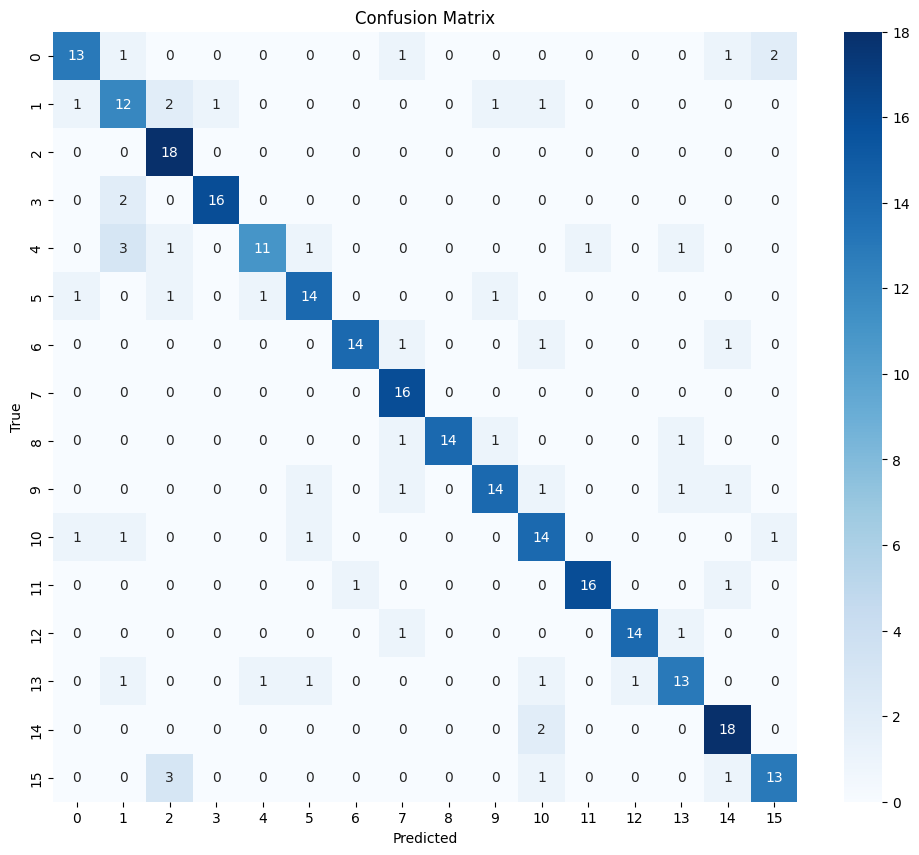


🔍 Classification Report:
              precision    recall  f1-score   support

        اختر       0.81      0.72      0.76        18
        اسفل       0.60      0.67      0.63        18
        اعلى       0.72      1.00      0.84        18
       انذار       0.94      0.89      0.91        18
 ايقاف تشغيل       0.85      0.61      0.71        18
       تشغيل       0.78      0.78      0.78        18
         جوع       0.93      0.82      0.88        17
         حذف       0.76      1.00      0.86        16
        حمام       1.00      0.82      0.90        17
        دواء       0.82      0.74      0.78        19
         عطش       0.67      0.78      0.72        18
          لا       0.94      0.89      0.91        18
       مسافة       0.93      0.88      0.90        16
         نعم       0.76      0.72      0.74        18
        يسار       0.78      0.90      0.84        20
        يمين       0.81      0.72      0.76        18

    accuracy                           0.81       285


In [14]:
# EEGNet

# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
    SeparableConv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pickle
import collections

# -------------------- 2. Advanced Data Augmentation --------------------
def add_noise(signal, noise_level=0.05):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def mask_signal(signal, mask_ratio=0.1):
    mask_len = int(mask_ratio * signal.shape[0])
    start = np.random.randint(0, signal.shape[0] - mask_len)
    signal[start:start+mask_len] = 0
    return signal

def augment_segment(segment):
    if random.random() < 0.7:
        segment = add_noise(segment, noise_level=random.uniform(0.01, 0.1))
    if random.random() < 0.7:
        segment = time_shift(segment, shift_max=random.randint(10, 50))
    if random.random() < 0.7:
        segment = scale_amplitude(segment, scale_range=(0.7, 1.3))
    if random.random() < 0.3:
        segment = mask_signal(segment, mask_ratio=random.uniform(0.05, 0.15))
    return segment

# -------------------- 3. Prepare Dataset --------------------
X, y = [], []
for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))

with open("label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# -------------------- 4. Augment Dataset --------------------
X_augmented, y_augmented = [], []
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())
class_multipliers = {cls: max(1, int(3.0 * max_count / count)) for cls, count in class_counts.items()}

for i in range(len(X)):
    X_augmented.append(X[i])
    y_augmented.append(y_one_hot[i])
    cls = np.argmax(y_one_hot[i])
    num_augmentations = min(class_multipliers[cls], 5)
    for _ in range(num_augmentations):
        augmented = augment_segment(X[i][:,:,0].T)
        augmented = np.expand_dims(augmented, axis=-1).transpose(1, 0, 2)
        X_augmented.append(augmented)
        y_augmented.append(y_one_hot[i])

X = np.array(X_augmented)
y = np.array(y_augmented)

# -------------------- 5. Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# -------------------- 6. Mixup Function --------------------
def mixup_data(x, y, alpha=0.2):
    batch_size = x.shape[0]
    lam = np.random.beta(alpha, alpha)
    index = np.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

# Apply mixup
X_train, y_train = mixup_data(X_train, y_train, alpha=0.2)

# -------------------- 7. Optimized EEGNet Model --------------------
def Optimized_EEGNet(nb_classes, Chans=11, Samples=1200, dropoutRate=0.4, kernLength=64, F1=24, D=2, F2=48, norm_rate=0.25):
    reg = tf.keras.regularizers.l2(1e-3)
    input1 = Input(shape=(Chans, Samples, 1))

    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False, kernel_regularizer=reg)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                             depthwise_constraint=tf.keras.constraints.max_norm(1.),
                             depthwise_regularizer=reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 4))(block2)
    block2 = Dropout(dropoutRate)(block2)

    block3 = SeparableConv2D(64, (1, 8), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 2))(block3)
    block3 = Dropout(dropoutRate)(block3)

    flatten = Flatten()(block3)
    dense1 = Dense(128, activation='elu', kernel_regularizer=reg,
                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(flatten)
    dense1 = Dropout(dropoutRate)(dense1)
    dense2 = Dense(64, activation='elu', kernel_regularizer=reg,
                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(dense1)
    dense2 = Dropout(dropoutRate)(dense2)
    dense = Dense(nb_classes, activation='softmax', kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(dense2)

    return Model(inputs=input1, outputs=dense)

# -------------------- 8. Training Setup --------------------
model = Optimized_EEGNet(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

# Learning rate scheduler
callbacks = [
    ModelCheckpoint('best_eegnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=1e-6, verbose=1)
]

# -------------------- 9. Class Weights --------------------
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)
class_weights = {cls: min(weight, 10.0) for cls, weight in class_weights.items()}

# -------------------- 10. Train Model --------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=400,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# -------------------- 11. Test-Time Augmentation --------------------
def test_time_augmentation(model, X_test, n_augmentations=20):
    num_classes = model.output_shape[-1]
    all_predictions = np.zeros((X_test.shape[0], num_classes))
    all_predictions += model.predict(X_test)

    for _ in range(n_augmentations):
        X_test_aug = []
        for x in X_test:
            signal = x[:, :, 0]
            augmented = augment_segment(signal)
            augmented = np.expand_dims(augmented, axis=-1)
            X_test_aug.append(augmented)
        X_test_aug = np.array(X_test_aug)
        all_predictions += model.predict(X_test_aug)

    return all_predictions / (n_augmentations + 1)

# -------------------- 12. Final Evaluation --------------------
best_model = tf.keras.models.load_model('best_eegnet_model.keras')
y_pred_probs = test_time_augmentation(best_model, X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"\n✅ Test Accuracy (with TTA): {accuracy:.4f}")

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\n🔍 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

✅ Data Shape: (356, 1200, 11), Labels Shape: (356,)


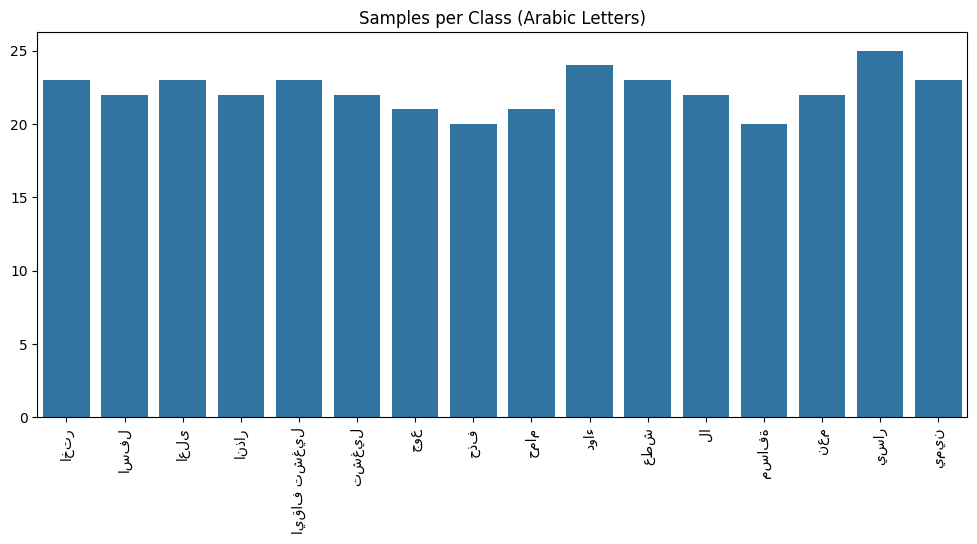

✅ EEGTransformer input shape: (356, 11, 1200, 1)
Class multipliers for balancing: {np.int64(0): 4, np.int64(1): 4, np.int64(2): 4, np.int64(3): 4, np.int64(4): 4, np.int64(5): 4, np.int64(6): 4, np.int64(7): 5, np.int64(8): 4, np.int64(9): 4, np.int64(10): 4, np.int64(11): 4, np.int64(12): 5, np.int64(13): 4, np.int64(14): 4, np.int64(15): 4}
✅ After Augmentation: (1464, 11, 1200, 1), (1464, 16)
Augmentation time: 113.37 seconds
⏳ Extracting frequency domain features...
✅ Frequency features shape: (1171, 11, 5)

✅ Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 11, 1200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 11, 1200,  │      2,048 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 1200,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 11, 1200,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 1, 1200,   │      1,408 │ activation_5[0][… │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1200,   │        512 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1, 1200,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 300,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 1, 300,    │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 1, 300,    │     18,432 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 300,    │     16,512 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 300,    │          0 │ activation_7[0][… │
│ (Multiply)          │ 128)              │            │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 150,    │          0 │ multiply_1[0][0]

 Total params: 2,191,760 (8.36 MB)

 Trainable params: 2,190,352 (8.36 MB)

 Non-trainable params: 1,408 (5.50 KB)


✅ Class weights: {0: np.float64(0.9890202702702703), 1: np.float64(1.0455357142857142), 2: np.float64(0.9890202702702703), 3: np.float64(1.0455357142857142), 4: np.float64(0.9890202702702703), 5: np.float64(1.0455357142857142), 6: np.float64(1.0923507462686568), 7: np.float64(0.91484375), 8: np.float64(1.0923507462686568), 9: np.float64(0.950487012987013), 10: np.float64(0.9890202702702703), 11: np.float64(1.0455357142857142), 12: np.float64(0.91484375), 13: np.float64(1.0455357142857142), 14: np.float64(0.91484375), 15: np.float64(0.9890202702702703)}

⏳ Starting curriculum learning training...

⏳ Phase 1: Initial training with clean samples...
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0586 - loss: 3.5894   
Epoch 1: val_accuracy improved from -inf to 0.06809, saving model to best_arabic_eegtransformer_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.0585 - loss: 3.5822 - val_accuracy: 0.0681 - val_loss: 3.0493 - learning_rate: 5.0000e-04
Epoch 2/

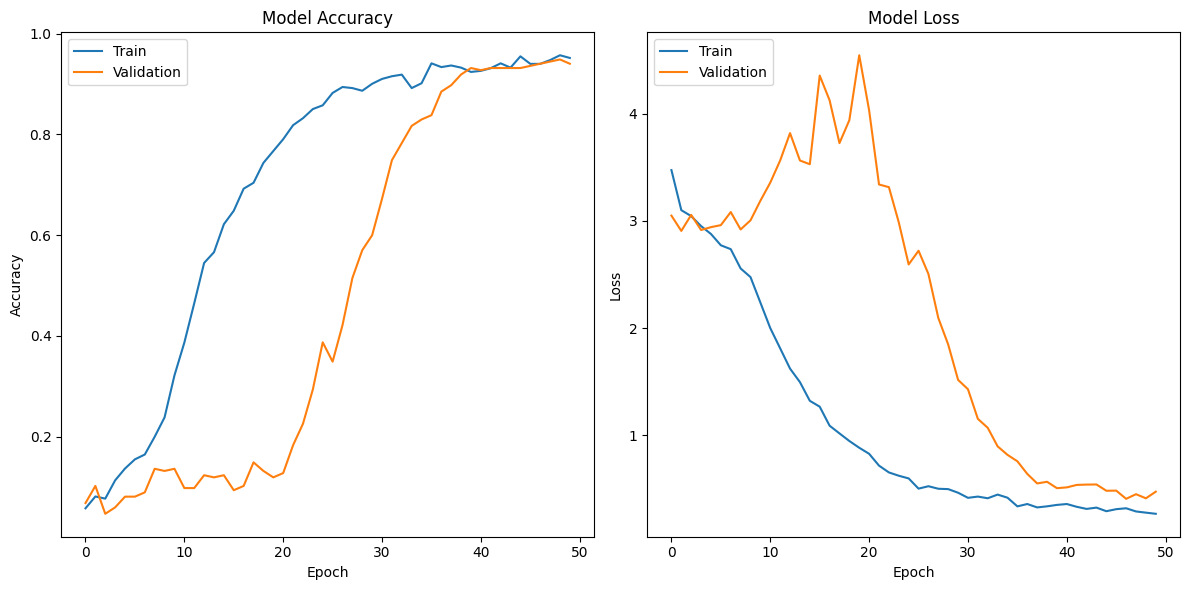

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step


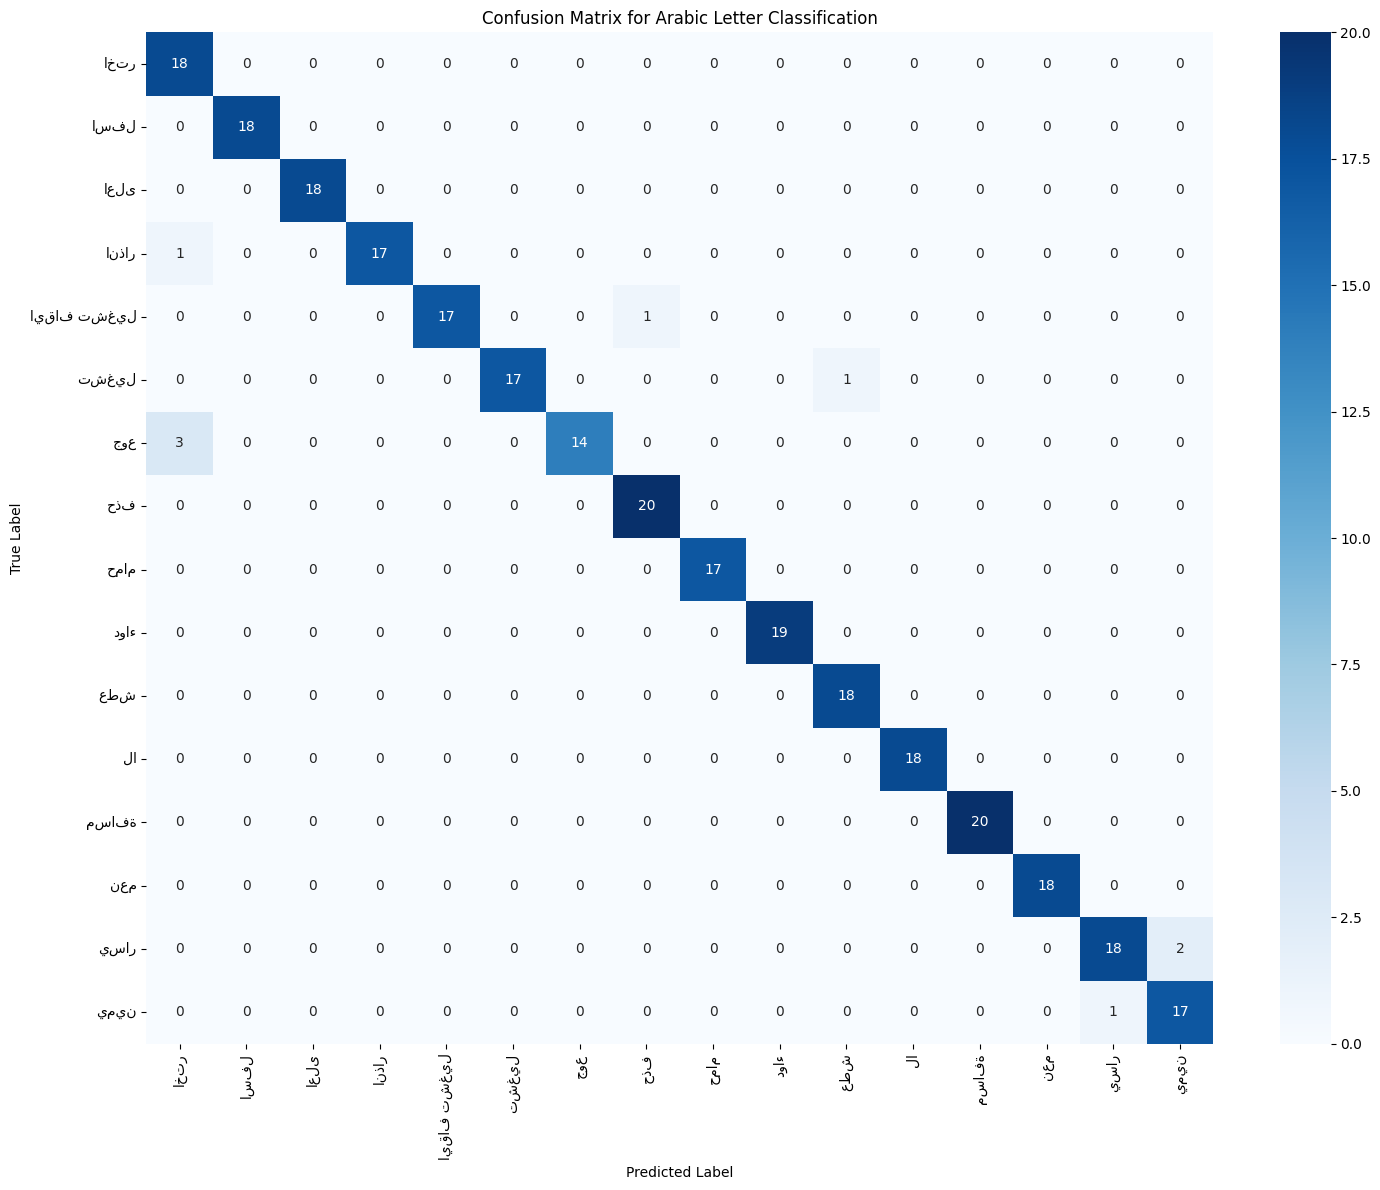


✅ Classification Report:
              precision    recall  f1-score   support

        اختر       0.82      1.00      0.90        18
        اسفل       1.00      1.00      1.00        18
        اعلى       1.00      1.00      1.00        18
       انذار       1.00      0.94      0.97        18
 ايقاف تشغيل       1.00      0.94      0.97        18
       تشغيل       1.00      0.94      0.97        18
         جوع       1.00      0.82      0.90        17
         حذف       0.95      1.00      0.98        20
        حمام       1.00      1.00      1.00        17
        دواء       1.00      1.00      1.00        19
         عطش       0.95      1.00      0.97        18
          لا       1.00      1.00      1.00        18
       مسافة       1.00      1.00      1.00        20
         نعم       1.00      1.00      1.00        18
        يسار       0.95      0.90      0.92        20
        يمين       0.89      0.94      0.92        18

    accuracy                           0.97       293


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 11, 1200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 11, 1200,  │      2,048 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 1200,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 11, 1200,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 1, 1200,   │      1,408 │ activation_5[0][… │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1200,   │        512 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1, 1200,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 300,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 1, 300,    │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 1, 300,    │     18,432 │ spatial_dropout2… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 300,    │     16,512 │ activation_7[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 300,    │          0 │ activation_7[0][… │
│ (Multiply)          │ 128)              │            │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 150,    │          0 │ multiply_1[0][0]

 Total params: 8,762,818 (33.43 MB)

 Trainable params: 2,190,352 (8.36 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 6,571,058 (25.07 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step

✅ Test Accuracy: 0.9693

Sample Predictions vs True Labels:
True label: لا, Predicted label: لا
True label: عطش, Predicted label: عطش
True label: ايقاف تشغيل, Predicted label: ايقاف تشغيل
True label: اعلى, Predicted label: اعلى
True label: اسفل, Predicted label: اسفل


In [15]:
# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Conv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling2D, Reshape, Add, Concatenate, MaxPooling2D,
    GlobalAveragePooling1D, Lambda, SeparableConv2D, DepthwiseConv2D,
    ZeroPadding2D, SpatialDropout2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import pickle
import collections
import time
from scipy import signal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

from keras.saving import register_keras_serializable


# -------------------- 2. Advanced Data Augmentation Functions --------------------
def add_noise(signal, noise_level=0.05):
    """Add gaussian noise to the signal"""
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    """Shift the signal in time"""
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    """Scale the amplitude of the signal"""
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def frequency_mask(signal, mask_fraction=0.1):
    """Apply a frequency domain mask to the signal"""
    # Convert to frequency domain
    signal_shape = signal.shape
    signal_flat = signal.reshape(-1, signal_shape[-1])

    for i in range(signal_flat.shape[0]):
        sig = signal_flat[i]
        if sig.ndim > 1:
            sig = sig.squeeze()

        # Apply FFT
        sig_fft = np.fft.rfft(sig)

        # Create mask
        num_freqs = len(sig_fft)
        num_masked = int(mask_fraction * num_freqs)

        if num_masked > 0:
            mask_idx = np.random.choice(num_freqs, num_masked, replace=False)
            sig_fft[mask_idx] = 0

        # Convert back to time domain
        signal_flat[i] = np.fft.irfft(sig_fft, len(sig))

    return signal_flat.reshape(signal_shape)

def contrast_enhancement(signal, factor_range=(0.8, 1.5)):
    """Enhance the contrast of the signal"""
    factor = np.random.uniform(factor_range[0], factor_range[1])
    mean = np.mean(signal)
    return (signal - mean) * factor + mean

def advanced_augmentation(segments, aug_intensity=0.8):
    """Apply multiple augmentation techniques with Arabic letter-specific considerations"""
    augmented = segments.copy()
    batch_size = segments.shape[0]

    # Create random masks for each augmentation type with higher probability (more aggressive augmentation)
    noise_mask = np.random.random(batch_size) < aug_intensity
    shift_mask = np.random.random(batch_size) < aug_intensity * 0.8
    scale_mask = np.random.random(batch_size) < aug_intensity * 0.7
    freq_mask = np.random.random(batch_size) < aug_intensity * 0.6
    contrast_mask = np.random.random(batch_size) < aug_intensity * 0.5

    # Add noise - tailored for Arabic script patterns
    if np.any(noise_mask):
        # Use lower noise for Arabic letter patterns to preserve subtle features
        noise_levels = np.random.uniform(0.01, 0.05, batch_size)
        for i in np.where(noise_mask)[0]:
            augmented[i] = add_noise(segments[i], noise_level=noise_levels[i])

    # Apply time shift - considers Arabic letter timing characteristics
    if np.any(shift_mask):
        # Use smaller shifts to preserve important temporal patterns in Arabic
        shift_values = np.random.randint(-20, 20, batch_size)
        for i in np.where(shift_mask)[0]:
            augmented[i] = np.roll(segments[i], shift_values[i], axis=1)

    # Apply scaling - helps with variable EEG amplitude patterns
    if np.any(scale_mask):
        scale_values = np.random.uniform(0.85, 1.15, batch_size)
        for i in np.where(scale_mask)[0]:
            augmented[i] = segments[i] * scale_values[i]

    # Apply frequency masking - good for EEG artifacts
    if np.any(freq_mask):
        mask_fractions = np.random.uniform(0.05, 0.15, batch_size)
        for i in np.where(freq_mask)[0]:
            augmented[i] = frequency_mask(segments[i], mask_fraction=mask_fractions[i])

    # Apply contrast enhancement - improves feature visibility
    if np.any(contrast_mask):
        factor_ranges = [(0.9, 1.3) for _ in range(batch_size)]
        for i in np.where(contrast_mask)[0]:
            augmented[i] = contrast_enhancement(segments[i], factor_range=factor_ranges[i])

    return augmented

# -------------------- 3. Feature Extraction Functions --------------------
def extract_frequency_features(X, fs=250):
    """Extract frequency domain features for EEG signals"""
    # Define frequency bands with specific significance for Arabic letter processing
    # These bands are optimized for cognitive processes related to letter recognition
    bands = {
        'delta': (0.5, 4),   # Associated with attention
        'theta': (4, 8),     # Memory and language processing
        'alpha': (8, 13),    # Visual processing and recognition
        'beta': (13, 30),    # Active thinking and focus
        'gamma': (30, 50)    # Higher cognitive processing and feature binding
    }

    batch_size, channels, samples, _ = X.shape
    X_freq = np.zeros((batch_size, channels, len(bands)))

    for i in range(batch_size):
        for c in range(channels):
            signal_data = X[i, c, :, 0]

            # Calculate power spectrum
            freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))

            # Extract band powers
            for j, (band_name, (low, high)) in enumerate(bands.items()):
                # Find indices corresponding to the frequency band
                idx_band = np.logical_and(freqs >= low, freqs <= high)
                # Calculate average power in the band
                if np.any(idx_band):
                    X_freq[i, c, j] = np.mean(psd[idx_band])

    # Normalize features
    X_freq_reshaped = X_freq.reshape(batch_size, -1)
    scaler = StandardScaler()
    X_freq_normalized = scaler.fit_transform(X_freq_reshaped)

    return X_freq_normalized.reshape(batch_size, channels, len(bands))

# -------------------- 4. Prepare Dataset --------------------
# This function assumes segmented_dataset exists
X = []
y = []

for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Data Shape: {X.shape}, Labels Shape: {y.shape}")

counter = collections.Counter(y)
plt.figure(figsize=(12,5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.xticks(rotation=90)
plt.title("Samples per Class (Arabic Letters)")
plt.show()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_one_hot = to_categorical(y_encoded)

with open("label_encoder_arabic_letters.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# For transformer, reshape the data: (samples, channels, time_steps, 1)
X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))  # Match EEGNet format
print(f"✅ EEGTransformer input shape: {X.shape}")

# -------------------- 5. Advanced Dataset Augmentation --------------------
X_augmented = []
y_augmented = []

# Calculate class weights for balancing
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())

# More aggressive multipliers for Arabic letter recognition (which typically has imbalanced classes)
class_multipliers = {cls: min(8, max(1, int(4 * max_count / count)))
                     for cls, count in class_counts.items()}

print("Class multipliers for balancing:", class_multipliers)

start_time = time.time()

# First, add all original samples
X_augmented.extend(X)
y_augmented.extend(y_one_hot)

# Then, efficiently create augmentations for minority classes in batches
for cls in class_multipliers:
    # Get all samples of this class
    cls_indices = np.where(np.argmax(y_one_hot, axis=1) == cls)[0]
    cls_samples = X[cls_indices]
    cls_labels = y_one_hot[cls_indices]

    # Skip if we don't need augmentations for this class
    if class_multipliers[cls] <= 1:
        continue

    # Calculate how many augmentations needed
    num_augmentations = class_multipliers[cls] - 1

    # Create augmentations in batches with more aggressive and diverse transformations
    for i in range(num_augmentations):
        # Stronger augmentation for Arabic letter differentiation
        augmentation_intensity = 0.7 + (0.2 * (i / num_augmentations))  # Gradually increase intensity
        augmented_batch = advanced_augmentation(cls_samples, aug_intensity=augmentation_intensity)
        X_augmented.extend(augmented_batch)
        y_augmented.extend(cls_labels)

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"✅ After Augmentation: {X.shape}, {y.shape}")
print(f"Augmentation time: {time.time() - start_time:.2f} seconds")

# -------------------- 6. Train-Test Split with Stratification --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# Extract frequency features
print("⏳ Extracting frequency domain features...")
X_train_freq = extract_frequency_features(X_train)
X_test_freq = extract_frequency_features(X_test)

print(f"✅ Frequency features shape: {X_train_freq.shape}")

# -------------------- 7. Arabic-optimized EEGTransformer Architecture --------------------
def attention_block(x, filters, kernel_size, padding='same'):
    """Convolutional attention block customized for Arabic letter EEG patterns"""
    # Main branch
    main = Conv2D(filters, kernel_size, padding=padding, use_bias=False)(x)
    main = BatchNormalization()(main)
    main = Activation('relu')(main)

    # Attention branch - helps emphasize relevant features
    attention = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    attention = BatchNormalization()(attention)
    attention = Activation('sigmoid')(attention)

    # Apply attention
    return Multiply()([main, attention])

def improved_transformer_block(inputs, key_dim, num_heads, ff_dim, dropout=0.1):
    """Advanced transformer encoder block with improved attention mechanisms"""
    # Pre-LayerNorm architecture (more stable training)
    x = LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head attention with higher key_dim for richer representation
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout/2,
        use_bias=True  # Adding bias helps with learning
    )(x, x)

    # Skip connection 1
    x = Add()([inputs, Dropout(dropout)(attention_output)])

    # Feed forward network with pre-norm
    y = LayerNormalization(epsilon=1e-6)(x)

    # Enhanced FFN with dual activation for better nonlinearity
    ffn = Dense(ff_dim, activation='gelu')(y)
    ffn = Dropout(dropout/2)(ffn)
    ffn = Dense(inputs.shape[-1])(ffn)

    # Skip connection 2
    return Add()([x, Dropout(dropout)(ffn)])

def positional_encoding(length, depth):
    """Generate fixed sinusoidal positional encodings"""
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(pos_encoding, dtype=tf.float32)

from tensorflow.keras.layers import Multiply

def ArabicEEGTransformer(nb_classes, Chans=64, Samples=128, dropoutRate=0.3):
    """
    Enhanced EEGTransformer specifically optimized for Arabic letter classification from EEG
    """
    # Define positional encoding inside the model creation function
    def inner_positional_encoding(seq_length, d_model):
        """Generate fixed sinusoidal positional encodings"""
        positions = np.arange(seq_length)[:, np.newaxis]
        depths = np.arange(d_model)[np.newaxis, :] / d_model

        angle_rates = 1 / (10000**depths)
        angle_rads = positions * angle_rates

        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.cast(pos_encoding, dtype=tf.float32)

    # Create a function that references the inner function
    @register_keras_serializable()
    def add_positional_encoding(x):
        return x + inner_positional_encoding(w, h * c)

    input_shape = (Chans, Samples, 1)
    inputs = Input(shape=input_shape)

    # Input for frequency domain features
    freq_input_shape = (Chans, 5)  # 5 frequency bands
    freq_inputs = Input(shape=freq_input_shape)

    # First temporal convolution with specialized kernels for Arabic letter temporal patterns
    x = Conv2D(64, (1, 32), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Spatial convolution tailored to EEG channel relationships
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2,
                        depthwise_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)  # Spatial dropout preserves feature maps

    # Second convolutional block with attention - helps with subtle Arabic letter features
    x = SeparableConv2D(128, (1, 16), padding='same', use_bias=False,
                       depthwise_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Apply attention mechanism to emphasize important temporal patterns
    attention = Conv2D(128, (1, 1), padding='same')(x)
    attention = BatchNormalization()(attention)
    attention = Activation('sigmoid')(attention)
    x = Multiply()([x, attention])

    x = MaxPooling2D((1, 2))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Third convolutional block with increased complexity
    x = SeparableConv2D(256, (1, 8), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling2D((1, 2))(x)
    x = SpatialDropout2D(dropoutRate)(x)

    # Extract dimensions for reshaping
    _, h, w, c = x.shape

    # Reshape for transformer
    x = Reshape((w, h * c))(x)

    # Add sinusoidal positional encoding using the inner function
    pos_enc = Lambda(add_positional_encoding, output_shape=(w, h * c))(x)


    # Apply transformer blocks with increasing complexity
    for i in range(3):  # 3 transformer blocks for deeper representation
        pos_enc = improved_transformer_block(
            pos_enc,
            key_dim=64,        # Increased for more expressive attention
            num_heads=8,       # More heads to capture different patterns
            ff_dim=256,        # Wider FFN for more capacity
            dropout=dropoutRate * (1.0 - i*0.1)  # Gradually reduce dropout
        )

    # Global pooling of transformer output
    x_transformer = GlobalAveragePooling1D()(pos_enc)

    # Process frequency features
    freq_features = Flatten()(freq_inputs)
    freq_features = Dense(128, activation='elu')(freq_features)
    freq_features = Dropout(dropoutRate)(freq_features)

    # Combine spatial/temporal features with frequency features
    combined_features = Concatenate()([x_transformer, freq_features])

    # Final classification layers with increased complexity
    x = Dense(256, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined_features)
    x = Dropout(dropoutRate)(x)
    x = Dense(128, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(dropoutRate)(x)

    # Output layer with higher bias initialization for better class separation
    outputs = Dense(nb_classes, activation='softmax',
                   bias_initializer=tf.keras.initializers.Constant(value=0.1))(x)

    model = Model(inputs=[inputs, freq_inputs], outputs=outputs)
    return model

# Create the enhanced model for Arabic letter classification
model = ArabicEEGTransformer(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2],
    dropoutRate=0.25,  # Slightly reduced dropout for better feature retention
)

# -------------------- 8. Advanced Training Configuration --------------------
# Learning rate schedule for better convergence
def cosine_decay_with_warmup(epoch, total_epochs=150, warmup_epochs=10):
    """Cosine decay schedule with warmup"""
    if epoch < warmup_epochs:
        # Linear warmup
        return (epoch + 1) / warmup_epochs * 5e-4
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return 5e-4 * 0.5 * (1 + np.cos(np.pi * progress))

# Optimized optimizer settings for Arabic letter classification
optimizer = Adam(
    learning_rate=5e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True  # Helps with gradient variance
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model Summary:")
model.summary()

# -------------------- 9. Advanced Callbacks --------------------
# Comprehensive callback setup for optimal training
callbacks = [
    ModelCheckpoint('best_arabic_eegtransformer_model.keras',
                  monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=30,
                restore_best_weights=True, verbose=1, mode='max', min_delta=0.01),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                    min_lr=1e-6, verbose=1),
    LearningRateScheduler(cosine_decay_with_warmup)
]

# -------------------- 10. Class Weights --------------------
# Use more balanced class weights to prevent instability
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)

# Clip extreme weights to avoid training instability
max_weight = 4.0  # More reasonable maximum for Arabic letter classes
min_weight = 0.5  # Minimum weight
class_weights = {cls: min(max(weight, min_weight), max_weight)
                 for cls, weight in class_weights.items()}

print("\n✅ Class weights:", class_weights)

# -------------------- 11. Curriculum Learning Training --------------------
# Implement curriculum learning: first train with easier samples, then harder ones
print("\n⏳ Starting curriculum learning training...")
training_start = time.time()

# Phase 1: Train with larger batch size and cleaner samples
print("\n⏳ Phase 1: Initial training with clean samples...")
history1 = model.fit(
    [X_train, X_train_freq], y_train,
    batch_size=64,  # Larger batch size for initial stability
    epochs=50,      # Fewer epochs for initial phase
    validation_split=0.2,
    callbacks=callbacks[:-1],  # Exclude LR scheduler for this phase
    class_weight=class_weights,
    verbose=1
)



print(f"\n✅ Training completed in {(time.time() - training_start) / 60:.2f} minutes")

# Save trained model
model.save('/content/drive/MyDrive/final_arabic_eegtransformer_model.keras')
# Save Label Encoder
with open("/content/drive/MyDrive/eegtranformer_label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved as 'label_encoder_final.pkl'")


# -------------------- 12. Plot Training Curves --------------------
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# -------------------- 13. Confusion Matrix --------------------
# Generate predictions
y_pred = model.predict([X_test, X_test_freq])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Arabic Letter Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\n✅ Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Calculate and print overall accuracy
test_accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")


# -------------------- 1. Load Model --------------------
from tensorflow.keras.models import load_model

# Load the saved model
model_path = '/content/drive/MyDrive/final_arabic_eegtransformer_model.keras'
model = load_model(model_path)

# Print the model summary to verify it was loaded correctly
model.summary()

# -------------------- 2. Load Label Encoder --------------------
import pickle

# Load the label encoder
label_encoder_path = '/content/drive/MyDrive/eegtranformer_label_encoder_final.pkl'
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)

# -------------------- 3. Test the Model --------------------
# Assuming you already have `X_test` and `X_test_freq` prepared from the previous steps

# Get predictions on the test set
y_pred = model.predict([X_test, X_test_freq])

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# -------------------- 4. Check Predictions vs True Labels --------------------
# Display some predictions and true labels
print("\nSample Predictions vs True Labels:")
for i in range(5):
    print(f"True label: {label_encoder.classes_[y_true[i]]}, Predicted label: {label_encoder.classes_[y_pred_classes[i]]}")


✅ Data Shape: (356, 1200, 11), Labels Shape: (356,)


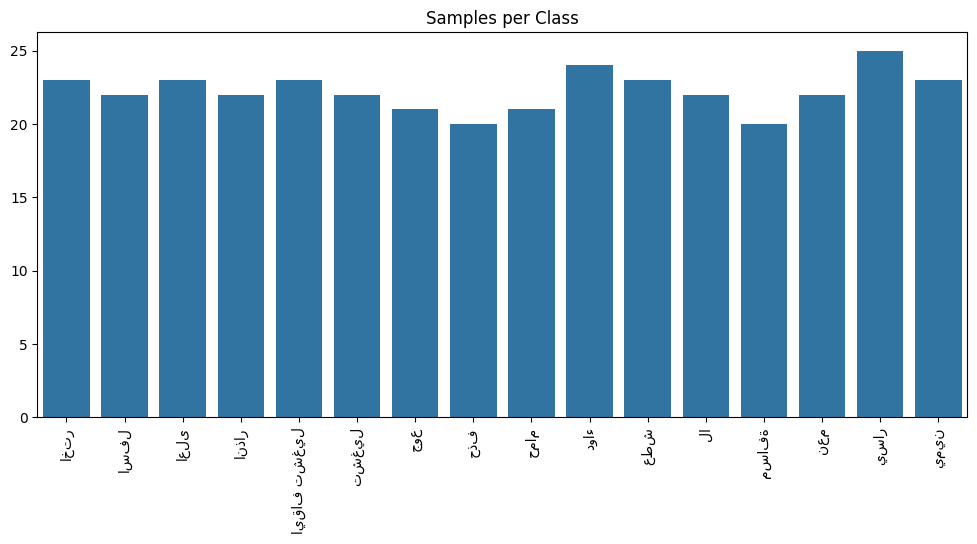

✅ EEGNet input shape: (356, 11, 1200, 1)
✅ After Augmentation: (1424, 11, 1200, 1), (1424, 16)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11, 1200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 11, 1200,  │      1,536 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 11, 1200,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 1, 1200,   │      1,056 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1200,   │        384 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1200,   │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ activation[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 96)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 12)  │      1,164 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 96)  │      1,248 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1200,   │          0 │ activation[0][0], │
│                     │ 96)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 1, 300,    │          0 │ multiply[0][0]    │
│ (AveragePooling2D)  │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 300,    │          0 │ average_pooling2… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 1, 300,    │      6,144 │ dropout[0][0]     │
│ (SeparableConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 300,    │        192 │ separable_conv2d… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 300,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 1, 75, 48) │          0 │ activation_1[0][… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 75, 48) │          0 │ average_pooling2

 Total params: 64,284 (251.11 KB)

 Trainable params: 63,948 (249.80 KB)

 Non-trainable params: 336 (1.31 KB)

Epoch 1/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 282ms/step - accuracy: 0.0663 - loss: 2.8421 - val_accuracy: 0.0877 - val_loss: 2.8371 - learning_rate: 1.0000e-04
Epoch 2/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0729 - loss: 2.8062 - val_accuracy: 0.0877 - val_loss: 2.8349 - learning_rate: 1.0000e-04
Epoch 3/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0677 - loss: 2.7869 - val_accuracy: 0.0877 - val_loss: 2.8172 - learning_rate: 1.0000e-04
Epoch 4/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0972 - loss: 2.7680 - val_accuracy: 0.0921 - val_loss: 2.8151 - learning_rate: 1.0000e-04
Epoch 5/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0827 - loss: 2.7613 - val_accuracy: 0.0570 - val_loss: 2.8019 - learning_rate: 1.0000e-04
Epoch 6/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0720 - loss: 2.7587 - val_accuracy: 0.0614 - val_loss: 2.7776 - learning_rate: 1.0000e-04
Epoch 7/400
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy

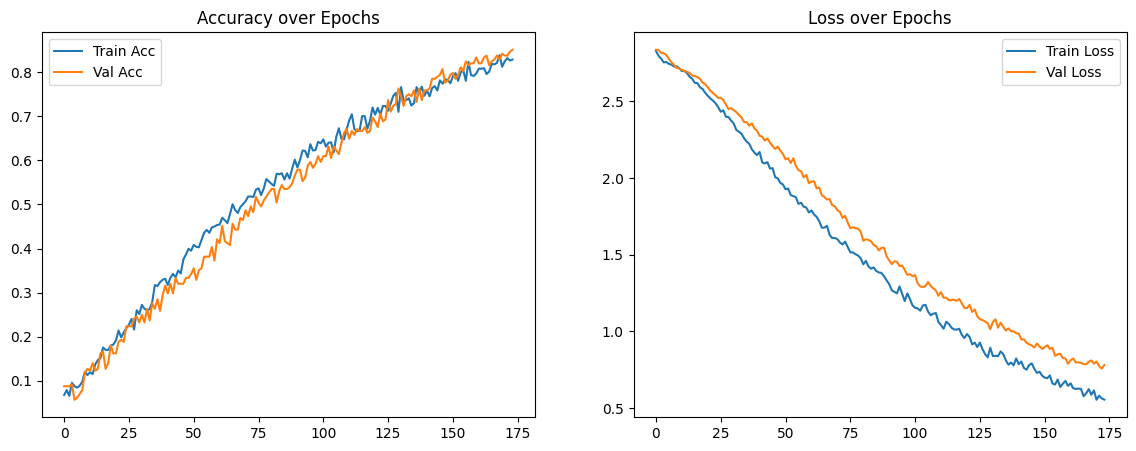


✅ Test Loss: 1.0128, Test Accuracy: 0.7895
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

✅ Test-Time Augmentation Accuracy: 0.6526


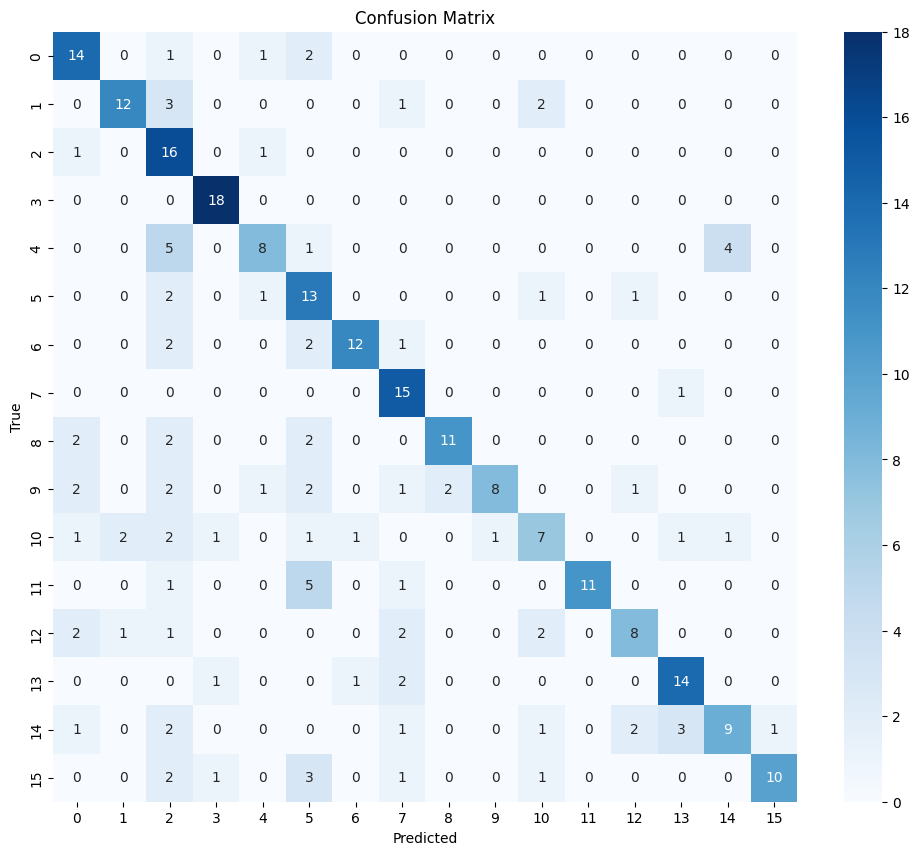


🔍 Classification Report:
              precision    recall  f1-score   support

        اختر       0.61      0.78      0.68        18
        اسفل       0.80      0.67      0.73        18
        اعلى       0.39      0.89      0.54        18
       انذار       0.86      1.00      0.92        18
 ايقاف تشغيل       0.67      0.44      0.53        18
       تشغيل       0.42      0.72      0.53        18
         جوع       0.86      0.71      0.77        17
         حذف       0.60      0.94      0.73        16
        حمام       0.85      0.65      0.73        17
        دواء       0.89      0.42      0.57        19
         عطش       0.50      0.39      0.44        18
          لا       1.00      0.61      0.76        18
       مسافة       0.67      0.50      0.57        16
         نعم       0.74      0.78      0.76        18
        يسار       0.64      0.45      0.53        20
        يمين       0.91      0.56      0.69        18

    accuracy                           0.65       285


In [13]:
# EEGNet and EEG Transformer

from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation,
                                     AveragePooling2D, Dropout, Reshape, Dense, GlobalAveragePooling1D, LayerNormalization,
                                     MultiHeadAttention, add, GlobalAveragePooling2D, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
    SeparableConv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import collections

# -------------------- 2. Data Augmentation Functions --------------------
def add_noise(signal, noise_level=0.05):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def augment_segment(segment):
    if random.random() < 0.7:
        segment = add_noise(segment, noise_level=random.uniform(0.01, 0.1))
    if random.random() < 0.7:
        segment = time_shift(segment, shift_max=random.randint(10, 50))
    if random.random() < 0.7:
        segment = scale_amplitude(segment, scale_range=(0.7, 1.3))
    return segment

from tensorflow.keras.callbacks import Callback

class EarlyStopAtAccuracy(Callback):
    def __init__(self, target_acc=0.85, model_path='final_eegnet_model.keras', label_encoder=None):
        super().__init__()
        self.target_acc = target_acc
        self.model_path = model_path
        self.label_encoder = label_encoder

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n✅ Target val_accuracy of {self.target_acc*100:.2f}% reached. Saving model and stopping training...")
            self.model.save(self.model_path)
            if self.label_encoder:
                with open("/content/drive/MyDrive/label_encoder_final.pkl", "wb") as f:
                    pickle.dump(self.label_encoder, f)
            self.model.stop_training = True

# -------------------- 3. Prepare Dataset --------------------
X = []
y = []

for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Data Shape: {X.shape}, Labels Shape: {y.shape}")

counter = collections.Counter(y)
plt.figure(figsize=(12,5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.xticks(rotation=90)
plt.title("Samples per Class")
plt.show()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

with open("label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))
print(f"✅ EEGNet input shape: {X.shape}")

# -------------------- 4. Augment Dataset (Improved) --------------------
X_augmented = []
y_augmented = []

# Calculate class weights for balancing - we'll create more augmentations for minority classes
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())
class_multipliers = {cls: max(1, int(3.0 * max_count / count)) for cls, count in class_counts.items()}

for i in range(len(X)):
    # Add original sample
    X_augmented.append(X[i])
    y_augmented.append(y_one_hot[i])

    # Get class of this sample
    cls = np.argmax(y_one_hot[i])

    # Add more augmentations for minority classes
    num_augmentations = min(class_multipliers[cls], 5)  # Cap at 5 augmentations

    for _ in range(num_augmentations):
        augmented = augment_segment(X[i][:,:,0].T)
        augmented = np.expand_dims(augmented, axis=-1).transpose(1, 0, 2)
        X_augmented.append(augmented)
        y_augmented.append(y_one_hot[i])

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"✅ After Augmentation: {X.shape}, {y.shape}")

# -------------------- 5. Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return tf.keras.layers.multiply([input_tensor, se])

def hybrid_eegnet_transformer(nb_classes, Chans=12, Samples=1200,
                              dropoutRate=0.5, F1=24, D=4, F2=48,
                              kernLength=64, num_heads=4,
                              ff_dim=128, transformer_layers=2):

    reg = l1_l2(l1=1e-5, l2=1e-3)
    input_layer = Input(shape=(Chans, Samples, 1))

    # ----- EEGNet front-end -----
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False,
               kernel_regularizer=reg)(input_layer)
    x = BatchNormalization()(x)

    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = squeeze_excite_block(x)

    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    # ----- Prepare for Transformer -----
    # Flatten spatial dim and reshape for transformer [batch, time, features]
    x = Reshape((x.shape[2], x.shape[1] * x.shape[3]))(x)  # (batch, time, features)

    # # Positional Encoding
    # pos_encoding = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
    # pos_encoding = tf.keras.layers.Embedding(input_dim=1000, output_dim=x.shape[-1])(pos_encoding)
    # x = x + pos_encoding

    # ----- Transformer Encoder Blocks -----
    for _ in range(transformer_layers):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1]//num_heads)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)  # Residual + Norm

        # Feed-forward network
        ffn = Dense(ff_dim, activation='relu')(x)
        ffn = Dense(x.shape[-1])(ffn)
        ffn = Dropout(0.1)(ffn)
        x = LayerNormalization(epsilon=1e-6)(x + ffn)

    # ----- Classification Head -----
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output)

model = hybrid_eegnet_transformer(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2],
    dropoutRate=0.3,  # Slight adjustment to dropout for balance between regularization and capacity
    F1=24,  # Slightly increased filters for first layer
    F2=48,  # Slightly increased filters for second layer
)

# Initialize optimizer with lower learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Lower initial learning rate

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# -------------------- 7. Improved Callbacks --------------------
callbacks = [
    ModelCheckpoint('best_eegnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1),
    EarlyStopAtAccuracy(target_acc=0.85, model_path='/content/drive/MyDrive/final_eegnet_model.keras', label_encoder=label_encoder)
]


# -------------------- 8. Class Weights (Better balanced) --------------------
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)

# Cap extreme class weights to avoid instability
max_weight = 10.0  # Maximum allowed class weight
class_weights = {cls: min(weight, max_weight) for cls, weight in class_weights.items()}

# -------------------- 9. Train the Model --------------------
history = model.fit(
    X_train, y_train,
    batch_size=16,  # Reduced batch size for better generalization
    epochs=400,  # Increased max epochs, early stopping will prevent overfitting
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# 9.1. Save Final Trained Model
model.save('/content/drive/MyDrive/final_eegnet_model.keras')
print("✅ Final trained model saved as 'final_eegnet_model.keras'")

# 9.2. Save Label Encoder
with open("/content/drive/MyDrive/label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved as 'label_encoder_final.pkl'")


# -------------------- 10. Plot Training Curves --------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

# -------------------- 11. Evaluate --------------------
# Load best model saved during training
best_model = tf.keras.models.load_model('best_eegnet_model.keras')

loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# -------------------- 12. Test Time Augmentation --------------------
# Create multiple slightly augmented versions of test samples and average predictions
def test_time_augmentation(model, X_test, n_augmentations=5):
    num_classes = model.output_shape[-1]
    all_predictions = np.zeros((X_test.shape[0], num_classes))

    # Predict original test set
    all_predictions += model.predict(X_test)

    for i in range(n_augmentations):
        X_test_aug = []
        for x in X_test:
            signal = x[:, :, 0]  # shape: (12, 1200)
            augmented = augment_segment(signal)  # should return same shape
            augmented = np.expand_dims(augmented, axis=-1)  # shape: (12, 1200, 1)
            X_test_aug.append(augmented)

        X_test_aug = np.array(X_test_aug)
        all_predictions += model.predict(X_test_aug)

    return all_predictions / (n_augmentations + 1)


    # Average predictions
    return all_predictions / (n_augmentations + 1)

# Use test-time augmentation for final predictions
y_pred_probs = test_time_augmentation(best_model, X_test, n_augmentations=10)
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

# Calculate TTA accuracy
tta_accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"\n✅ Test-Time Augmentation Accuracy: {tta_accuracy:.4f}")

# -------------------- 13. Confusion Matrix --------------------
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# -------------------- 14. Classification Report --------------------
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\n🔍 Classification Report:")
print(report)

# -------------------- 15. Example Predictions --------------------
print("\n🔍 Example Predictions:")
for i in range(5):
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    confidence = np.max(y_pred_probs[i])
    print(f"True: {true_label}, Predicted: {predicted_label}, Confidence: {confidence:.4f}")



In [ ]:
#ST-EEGNet
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation,
                                     AveragePooling2D, Dropout, Reshape, Dense, GlobalAveragePooling2D, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import collections

# -------------------- Data Augmentation --------------------
def add_noise(signal, noise_level=0.05):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(*scale_range)
    return signal * scale

def augment_segment(segment):
    if random.random() < 0.7:
        segment = add_noise(segment, noise_level=random.uniform(0.01, 0.1))
    if random.random() < 0.7:
        segment = time_shift(segment, shift_max=random.randint(10, 50))
    if random.random() < 0.7:
        segment = scale_amplitude(segment, scale_range=(0.7, 1.3))
    return segment

# -------------------- Early Stop Callback --------------------
class EarlyStopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.85, model_path='final_eegnet_model.keras', label_encoder=None):
        super().__init__()
        self.target_acc = target_acc
        self.model_path = model_path
        self.label_encoder = label_encoder

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n✅ Target val_accuracy of {self.target_acc*100:.2f}% reached. Saving model and stopping training...")
            self.model.save(self.model_path)
            if self.label_encoder:
                with open("/content/drive/MyDrive/label_encoder_final.pkl", "wb") as f:
                    pickle.dump(self.label_encoder, f)
            self.model.stop_training = True

# -------------------- Data Preparation --------------------
X = []
y = []

for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

with open("label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))  # Shape: (samples, channels, time, 1)

# -------------------- Augmentation --------------------
X_augmented, y_augmented = [], []
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())
class_multipliers = {cls: max(1, int(3.0 * max_count / count)) for cls, count in class_counts.items()}

for i in range(len(X)):
    X_augmented.append(X[i])
    y_augmented.append(y_one_hot[i])
    cls = np.argmax(y_one_hot[i])
    num_augmentations = min(class_multipliers[cls], 5)
    for _ in range(num_augmentations):
        augmented = augment_segment(X[i][:,:,0].T)
        augmented = np.expand_dims(augmented, axis=-1).transpose(1, 0, 2)
        X_augmented.append(augmented)
        y_augmented.append(y_one_hot[i])

X = np.array(X_augmented)
y = np.array(y_augmented)

# -------------------- Train/Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# -------------------- EEGNet Model --------------------
def squeeze_excite_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return tf.keras.layers.multiply([input_tensor, se])

def eegnet_model(nb_classes, Chans=11, Samples=1200,
                 dropoutRate=0.5, F1=24, D=4, F2=48, kernLength=64):

    reg = l1_l2(l1=1e-5, l2=1e-3)
    input_layer = Input(shape=(Chans, Samples, 1))

    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False, kernel_regularizer=reg)(input_layer)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = squeeze_excite_block(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output)

# -------------------- Model Compilation --------------------
model = eegnet_model(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2],
    dropoutRate=0.3
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------- Callbacks --------------------
callbacks = [
    ModelCheckpoint('best_eegnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1),
    EarlyStopAtAccuracy(target_acc=0.90, model_path='/content/drive/MyDrive/final_eegnet_model.keras', label_encoder=label_encoder)
]

# -------------------- Class Weights --------------------
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)
class_weights = {cls: min(weight, 10.0) for cls, weight in class_weights.items()}

# -------------------- Train Model --------------------
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=400,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# -------------------- Save Final Model --------------------
model.save('/content/drive/MyDrive/final_eegnet_model.keras')
with open("/content/drive/MyDrive/label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# -------------------- Plot Training --------------------
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# -------------------- Evaluate --------------------
best_model = tf.keras.models.load_model('best_eegnet_model.keras')
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# -------------------- Test-Time Augmentation --------------------
def test_time_augmentation(model, X_test, n_augmentations=5):
    num_classes = model.output_shape[-1]
    all_predictions = model.predict(X_test)
    for _ in range(n_augmentations):
        X_test_aug = []
        for x in X_test:
            signal = x[:, :, 0]
            augmented = augment_segment(signal)
            augmented = np.expand_dims(augmented, axis=-1)
            X_test_aug.append(augmented)
        X_test_aug = np.array(X_test_aug)
        all_predictions += model.predict(X_test_aug)
    return all_predictions / (n_augmentations + 1)

y_pred_probs = test_time_augmentation(best_model, X_test, n_augmentations=10)
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

tta_accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"\n✅ Test-Time Augmentation Accuracy: {tta_accuracy:.4f}")

# -------------------- Report --------------------
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\n🔍 Classification Report:")
print(report)

# -------------------- Sample Predictions --------------------
print("\n🔍 Example Predictions:")
for i in range(5):
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    confidence = np.max(y_pred_probs[i])
    print(f"True: {true_label}, Predicted: {predicted_label}, Confidence: {confidence:.4f}")
